In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

# Import own libraries 
import os, sys
script_path = os.path.realpath(os.path.dirname("10_on_trajectories"))
os.chdir(script_path)
sys.path.append("..")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
HOLE_SIZE = 28
ACTIVITY = 0
MIN_PUBS = 0
EVENTS = get_collabs_event()
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[1: -3]
EVENTS_TO_CONSIDER = EVENTS[1: -3]

# **Logarithmic Trajectories**

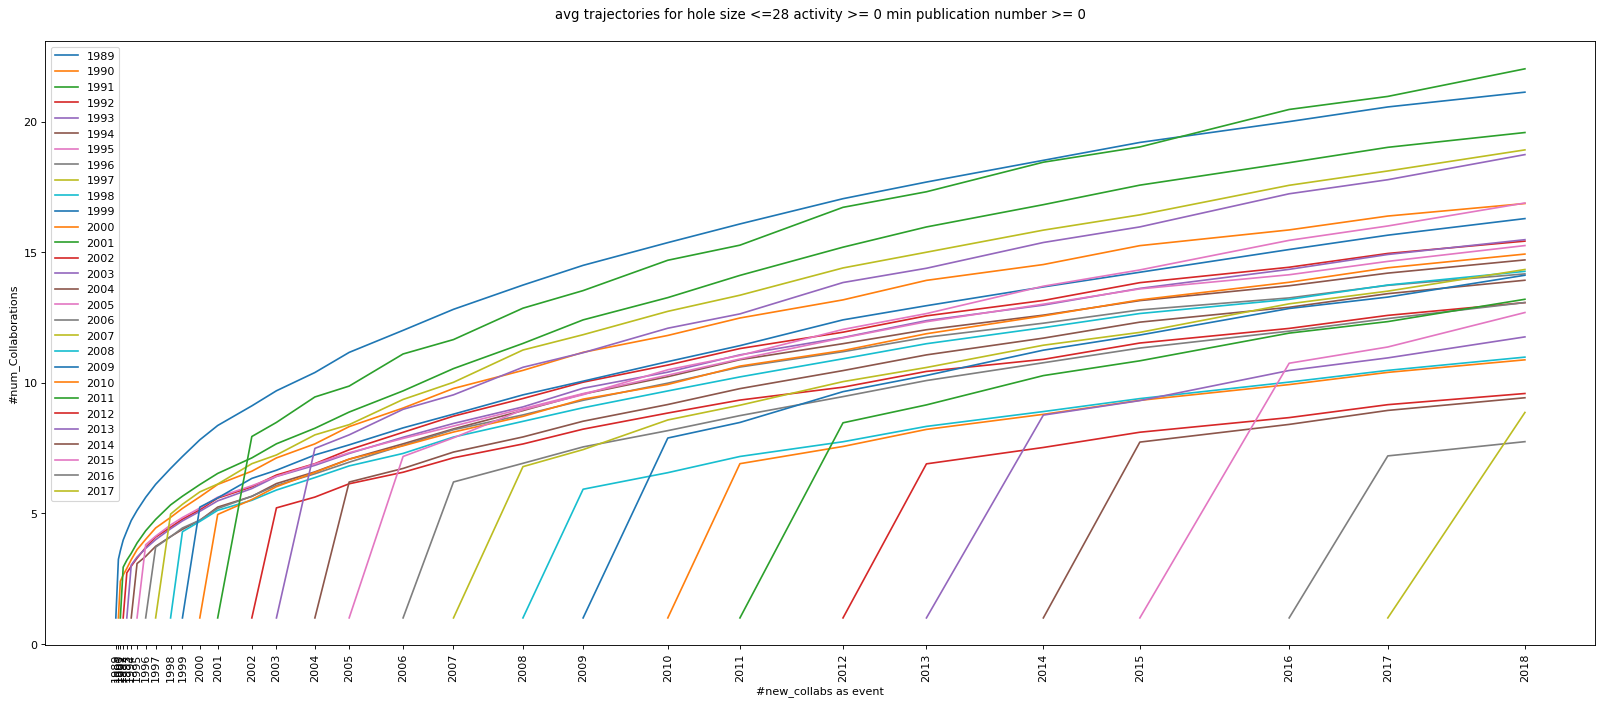

In [3]:
## Plot average trajectories 
plt.figure(figsize=(25, 10), dpi=80)
plt.title("avg trajectories for hole size <=" + str(HOLE_SIZE) + " activity >= " + str(ACTIVITY)+ " min publication number >= " + str(MIN_PUBS) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, activity=ACTIVITY, minPubs=MIN_PUBS)
    
    if(len(y)==1):
        plt.scatter(x,y)
    else:
        plt.plot(x,y)
    
    plt.xticks(x, y)
    plt.xticks(rotation='vertical')
    
plt.legend(YEARS, loc='upper left')
plt.xticks(EVENTS, YEARS)
plt.show()

# **(2) Plotting fitting function**

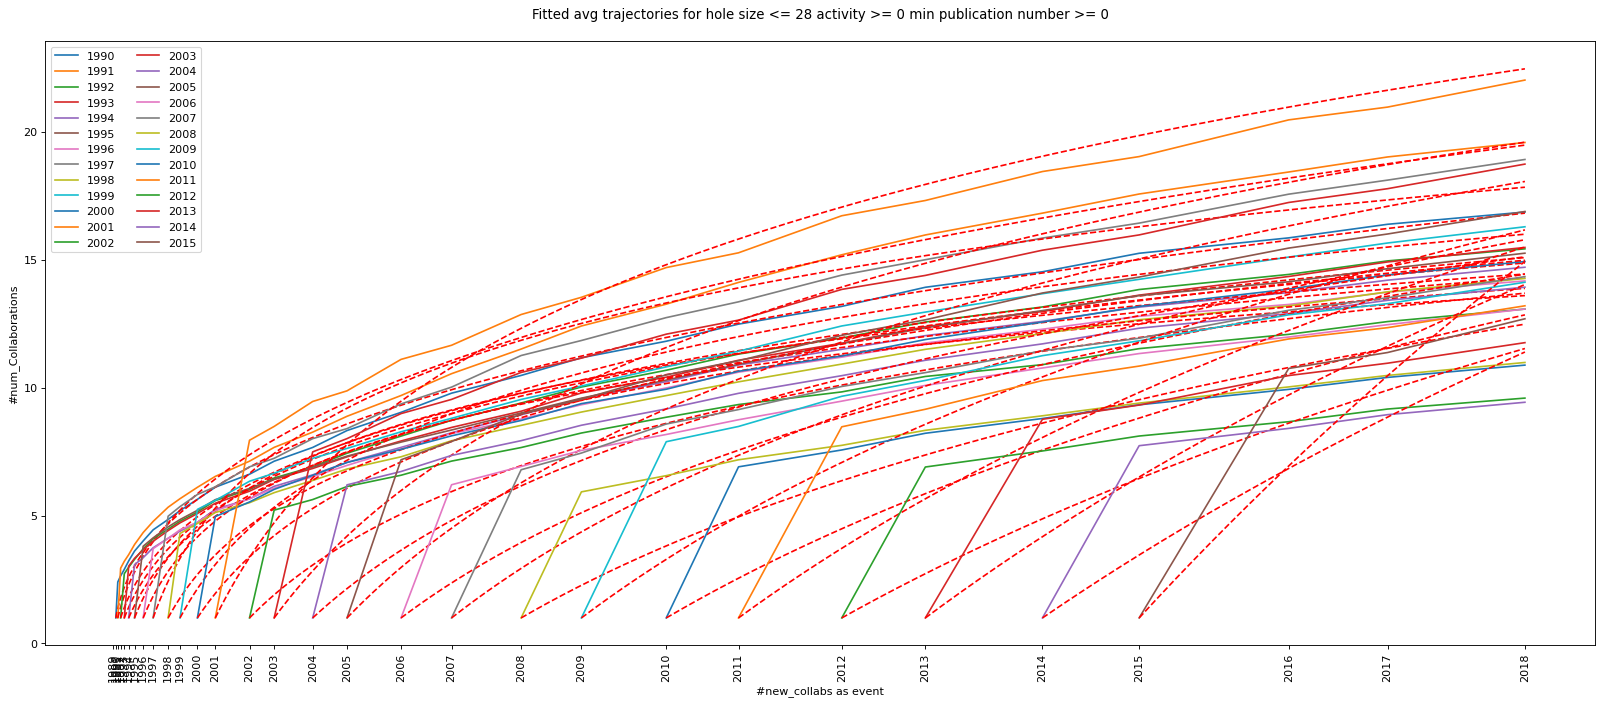

In [3]:
## Plot fitted average trajectories
plt.figure(figsize=(25, 10), dpi=80)
plt.title("Fitted avg trajectories for hole size <= " + str(HOLE_SIZE ) + " activity >= " + str(ACTIVITY)+ " min publication number >= " + str(MIN_PUBS) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

alphas = []
betas = []
for start_y in YEARS_TO_CONSIDER:
    
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size)     
    
    fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
    
    xdata = [a for a in range(x[0], x[-1])]
    fit_y = theoretical_func(xdata, alpha, beta, x[0])

    # save fitted parameters alpha, beta
    alphas.append(alpha)
    betas.append(beta)
        
    plt.plot(x,y, label=str(start_y))
    plt.plot(xdata, fit_y, 'r--')
   
plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=2)
plt.xticks(EVENTS, YEARS)
plt.show()

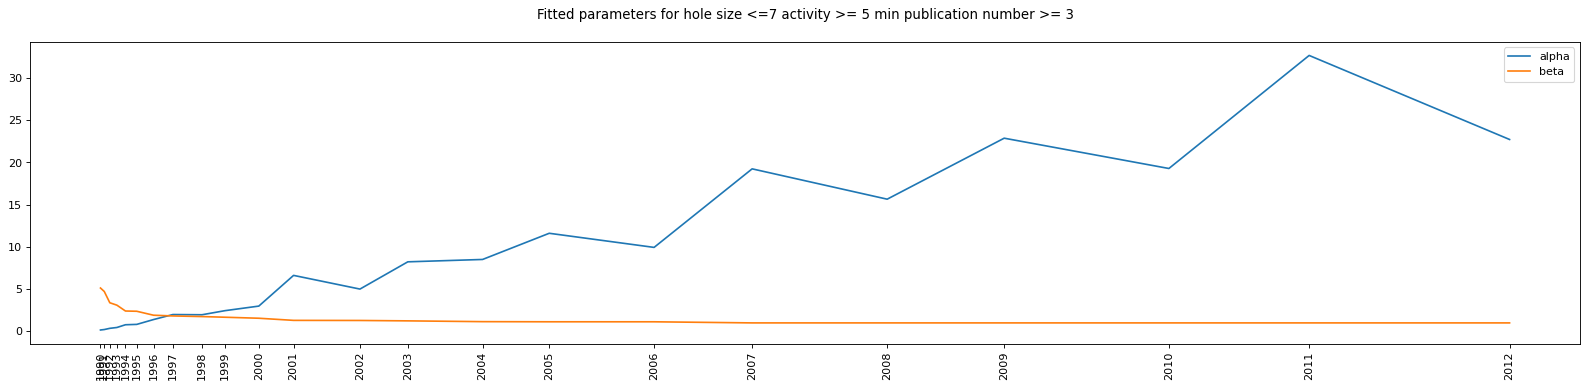

   start_y      alpha      beta
0     1990   0.160100  5.128629
1     1991   0.213555  4.717951
2     1992   0.356918  3.384121
3     1993   0.456557  3.099070
4     1994   0.780497  2.406859
5     1995   0.823750  2.377335
6     1996   1.395841  1.909496
7     1997   1.989427  1.823355
8     1998   1.964117  1.749870
9     1999   2.448626  1.670823
10    2000   2.989074  1.551872
11    2001   6.624379  1.299609
12    2002   5.004167  1.287509
13    2003   8.229501  1.240957
14    2004   8.509432  1.147803
15    2005  11.608522  1.131748
16    2006   9.937668  1.130683
17    2007  19.235300  1.000000
18    2008  15.645318  1.000000
19    2009  22.864914  1.000000
20    2010  19.278010  1.000000
21    2011  32.658967  1.000000
22    2012  22.711273  1.000000


In [9]:
## Plotting and Printing fitted parameters alpha and beta for each starting year
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted parameters for hole size <=" + str(HOLE_SIZE) + " activity >= " + str(ACTIVITY)+ " min publication number >= " + str(MIN_PUBS) + "\n", fontdict = {'fontsize' : 12})

plt.plot(EVENTS_TO_CONSIDER, alphas, label="alpha")
plt.plot(EVENTS_TO_CONSIDER, betas, label="beta")
plt.xticks(EVENTS_TO_CONSIDER, YEARS_TO_CONSIDER)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

print(pd.DataFrame([[YEARS_TO_CONSIDER[i], alphas[i], betas[i]] for i in range(len(alphas))], columns=["start_y", "alpha", "beta"]))

# **(3)** Find **alpha\* and beta\*** to have a function **f\*** minimizing the **errors**

given a starting event $i$:
- Let $e$ be a generic event
- Let $r_i(e)$ be the function representing the real average trajectory for authors who started to publish at the event $i$
- Let $f_i(e)$ be the fitted function of $r_i(e)$
- Let $f_i^*(e)$ be the general fitting function of which we want to optimized the parameters, for authors who started to publish at the event $i$

#### A) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$
#### B) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$ 

#### C) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 
#### D) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 

In [10]:
 ##### ERRORS FUNCTIONS FOR AVERAGE TRAJECTORIES #####

YEARS = get_str_years_event()

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
            err += pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)

    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_B(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        
        tmp = []
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
        
            tmp.append(pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2))
        err += np.max(tmp)
    
    sys.stdout.write('\r'+ "optimizing B function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200 # the next error function works on all events, choose the number of event to be considered 

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)    
        curr_x = xdata[i]  
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        

        for e in events_subset:
            if(e>curr_x):
                err += pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2)

    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_D(params, xdata, hole_size, years_to_consider=YEARS):
    
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
    
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        
        curr_x = xdata[i]  

        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 

        tmp = []
        for e in events_subset:
            if(e>curr_x):
                tmp.append(pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2))
             
        if((len(tmp))!=0):
            err += np.max(tmp)
        
    sys.stdout.write('\r'+ "optimizing D function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

In [7]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]

start_params = [1, 1]
bnds = ((0, None), (1, None))

# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 

result_A = minimize(err_f_A, start_params, args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_B = minimize(err_f_B, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_B = result_B.x
alphas_opt.append(fitted_params_B[0])
betas_opt.append(fitted_params_B[1])
errs.append(err_f_B(fitted_params_B, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()


result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_D = minimize(err_f_D, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_D = result_D.x
alphas_opt.append(fitted_params_D[0])
betas_opt.append(fitted_params_D[1])
errs.append(err_f_D(fitted_params_D, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))

optimizing A function with -> params: [3.11082898 1.        ], error: 8616.0273536395944
optimizing B function with -> params: [3.79072638 1.        ], error: 1152.2140936285377
optimizing C function with 200 events -> params: [3.41687658 1.        ], error: 113714.14022342156
optimizing D function with 200 events -> params: [4.04633479 1.        ], error: 1566.4647309629916

                 ERROR     alpha  beta
err_f_A    8616.027354  3.110829   1.0
err_f_B    1152.214094  3.790726   1.0
err_f_C  113714.140223  3.416877   1.0
err_f_D    1566.464731  4.046335   1.0


In [12]:
alphas_opt = [3.11082898, 3.79072638, 3.41687658, 4.04633479]
betas_opt = [1, 1, 1, 1 ]
errs = [8616.0273536395944, 1152.2140936285377, 113714.14022342156, 1566.4647309629916]

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))


                 ERROR     alpha  beta
err_f_A    8616.027354  3.110829     1
err_f_B    1152.214094  3.790726     1
err_f_C  113714.140223  3.416877     1
err_f_D    1566.464731  4.046335     1


# **(4) Shift fitted trajectories, compute their average and fit it**

In [4]:
# Shift all fitted trajectories
shifted_funcs = []

i = 0
for i in range(len(alphas)):
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER[i], activity=ACTIVITY, minPubs=MIN_PUBS)

    xdata = [e+x[0] for e in ALL_EVENTS]        
    f = theoretical_func(xdata, alphas[i], betas[i], x[0])

    shifted_funcs.append(f) # add function to the set
    i+=1
    
# compute the average of the shifted functions
avg_shift = np.average(np.array(shifted_funcs), axis=0)

In [5]:
# fit the average curve
fit_avg_shift, alpha, beta = fit_trajectory(ALL_EVENTS, avg_shift) 

print("The fitted parameters are:")
print(" alpha*:", alpha, "\n beta*:", beta)

The fitted parameters are:
 alpha*: 5.221157000820071e-05 
 beta*: 3508.4277723664586


In [6]:
alpha, beta = 5.221157000820071e-05, 3508.4277723664586
fit_avg_shift = theoretical_func(ALL_EVENTS, alpha, beta, np.int64(1))

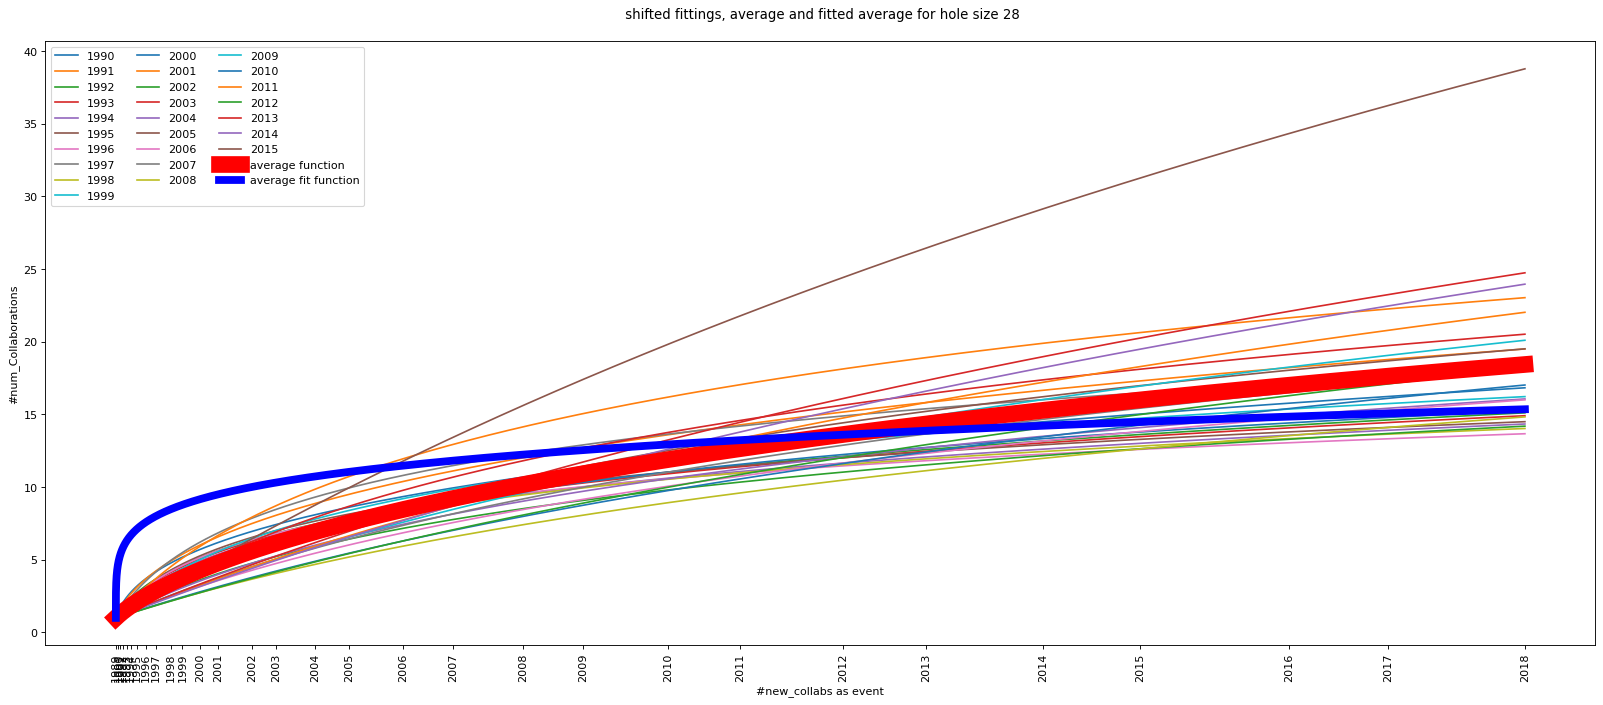

In [10]:
# plot shifted trajectories, theri average and tit's fitting
plt.figure(figsize=(25, 10), dpi=80)
plt.title(" shifted fittings, average and fitted average for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

j = 0
for start_y in YEARS_TO_CONSIDER:
    plt.plot(ALL_EVENTS,shifted_funcs[j], label=start_y)
    j = j+1       
    
plt.plot(ALL_EVENTS, avg_shift, 'r-+', label="average function",  linewidth=15.0)
plt.plot(ALL_EVENTS, fit_avg_shift, 'b-', label="average fit function", linewidth=7.0)

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=3)
plt.xticks(EVENTS, YEARS)
plt.show()

# **(5) compare general fitting error functions A,B,C and D with the general average fitted one**  

### Error fitted trajectories

In [13]:
## get general fitting functions by starting year for each couple of parameter found above 
error_f_labels = ["A", "B", "C", "D"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = theoretical_func(xdata, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)

    error_fit_functions[error_f_labels[i]] = functions_by_start_y

### Average fitted trajectories

In [14]:
## get general fitting functions for each starting year for alpha* and beta* of the fitted average
average_fit_functions = [] # contains fitted error functions for each year 
for start_y in YEARS_TO_CONSIDER:

    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    xdata = [e-x[0] for e in range(x[0],x[-1])]
    
    general_fit_y = theoretical_func(xdata, alpha, beta, np.int64(1))
    average_fit_functions.append(general_fit_y)

### **plot everything**

In [17]:
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
def plot_all(start_y):
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions with the general average fitted one for the starting year " + start_y + " for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    plt.plot(x,y, label="real data")

    xdata = [e for e in range(x[0],x[-1])]

    for i in range(len(error_f_labels)):
        err_f = error_fit_functions[error_f_labels[i]][j]
        plt.plot(xdata, err_f, label="error fit function "+ error_f_labels[i])

    plt.plot(xdata, average_fit_functions[j], label="average fit function")

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')    
    plt.xticks(x, YEARS[YEARS.index(start_y):])
    plt.show()

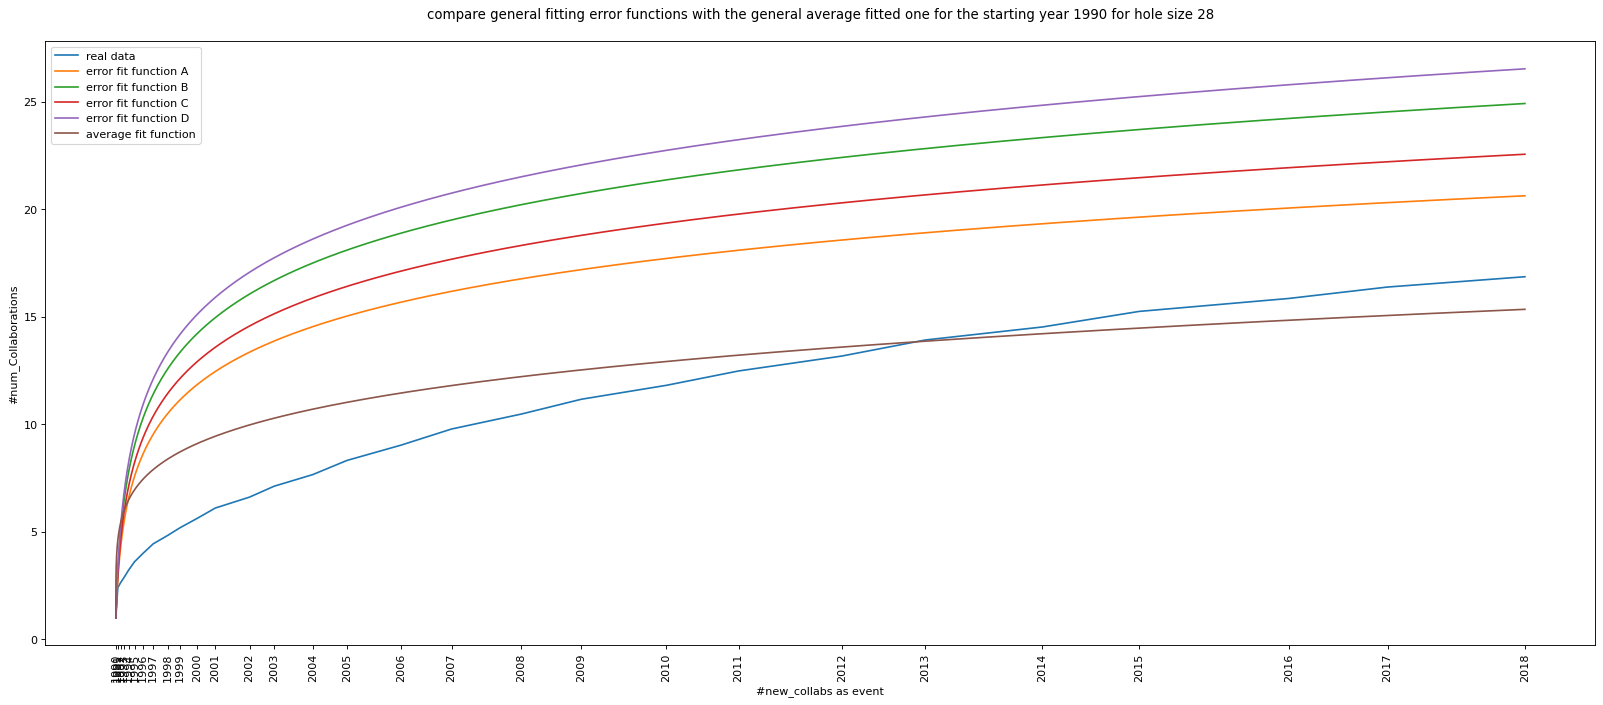

In [18]:
plot_all("1990")

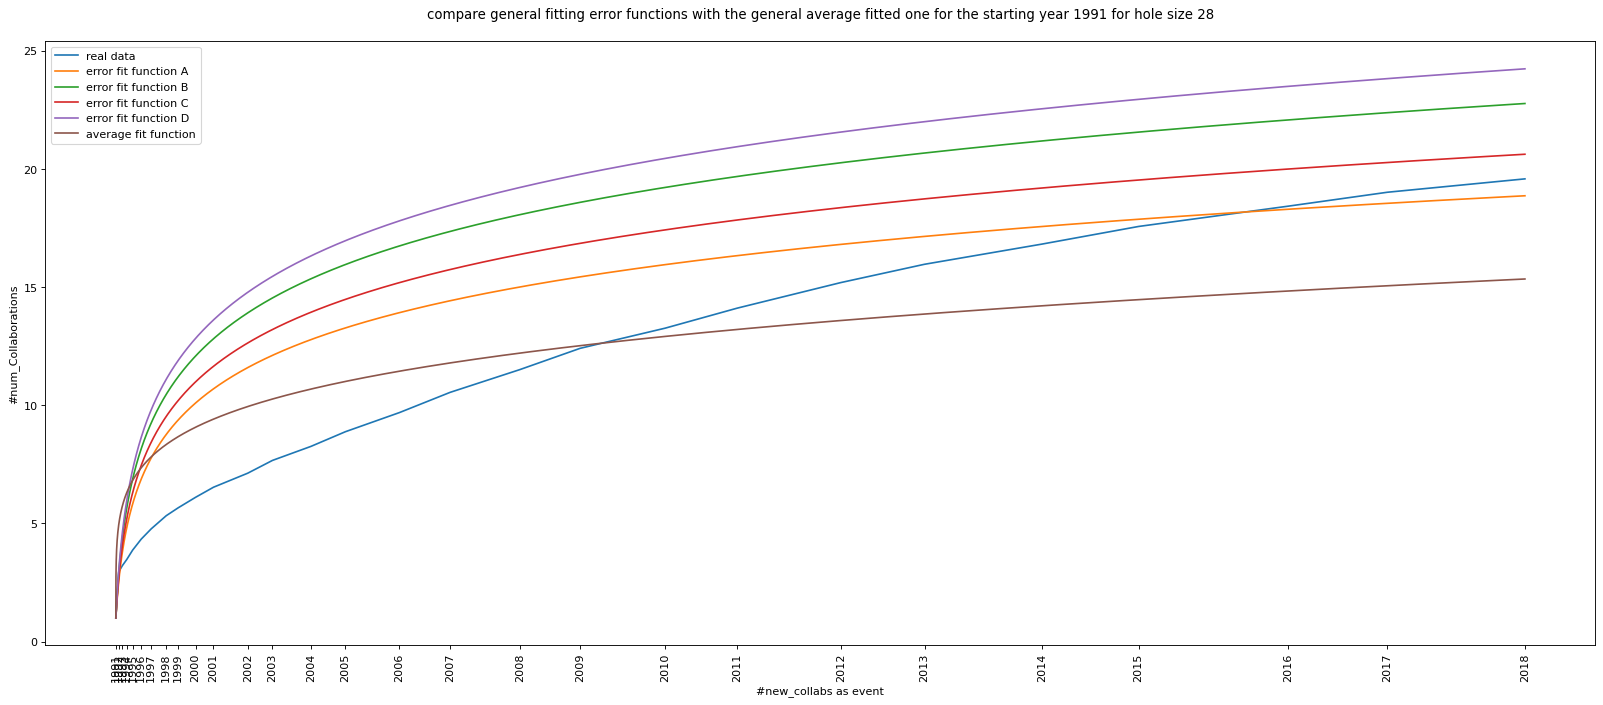

In [19]:
plot_all("1991")

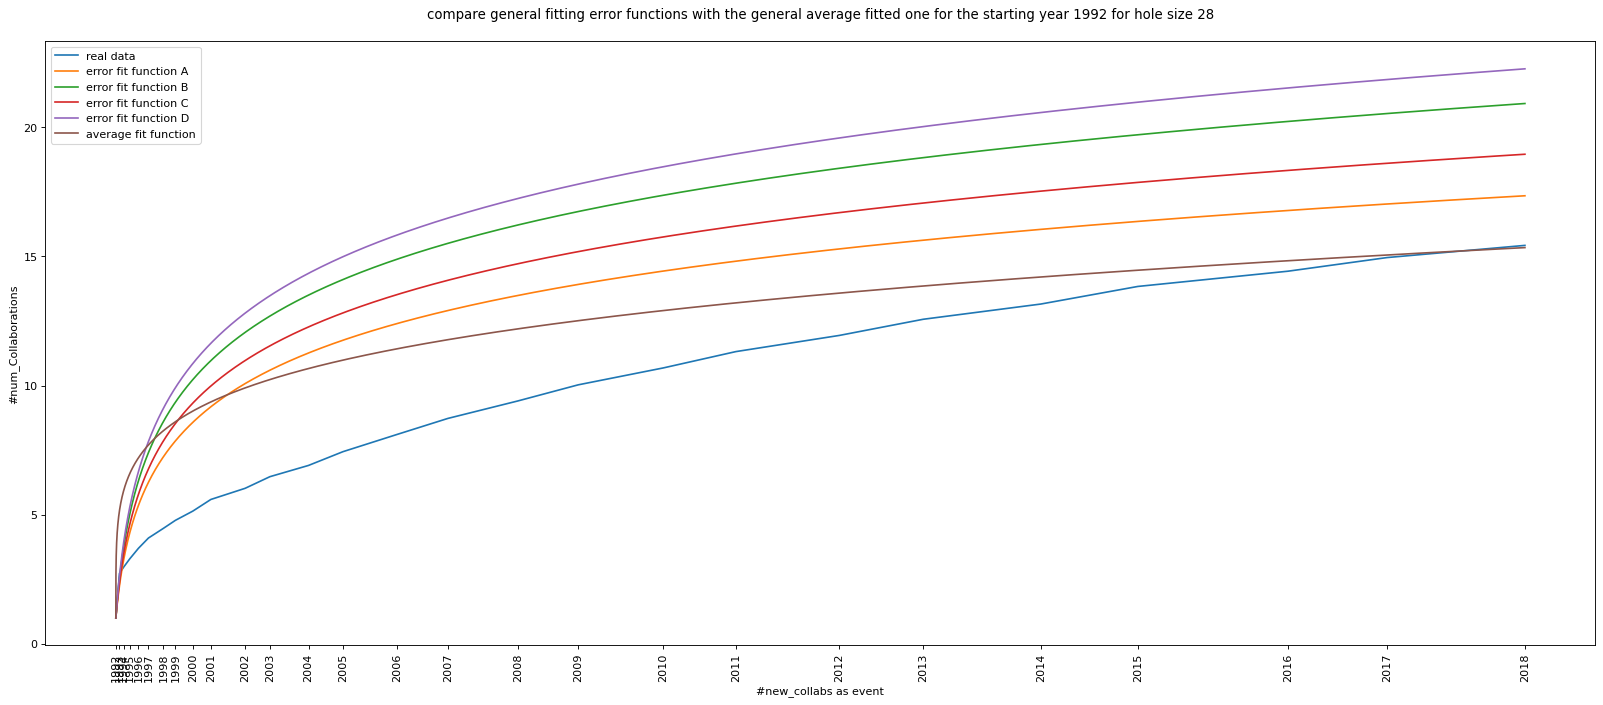

In [16]:
plot_all("1992")

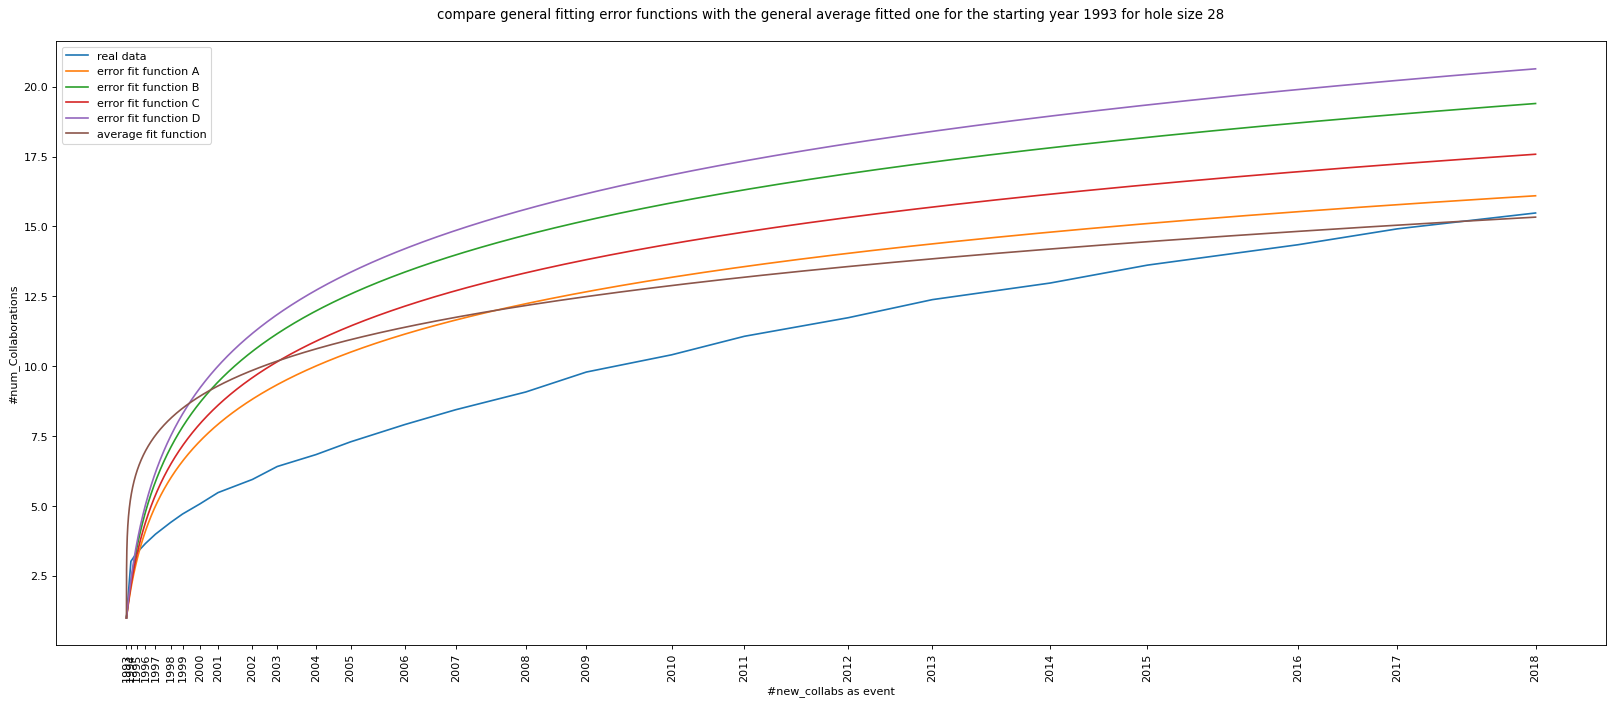

In [17]:
plot_all("1993")

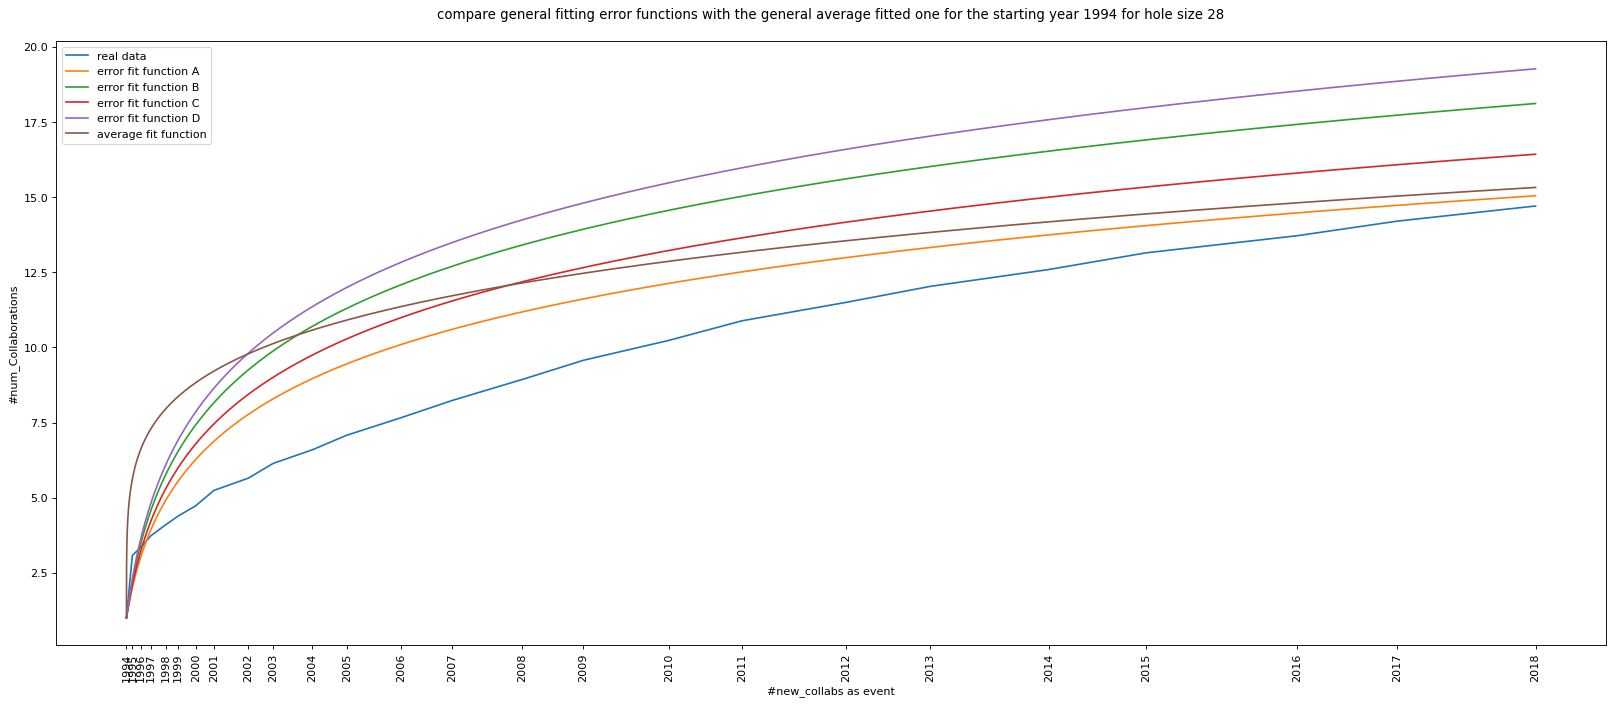

In [18]:
plot_all("1994")

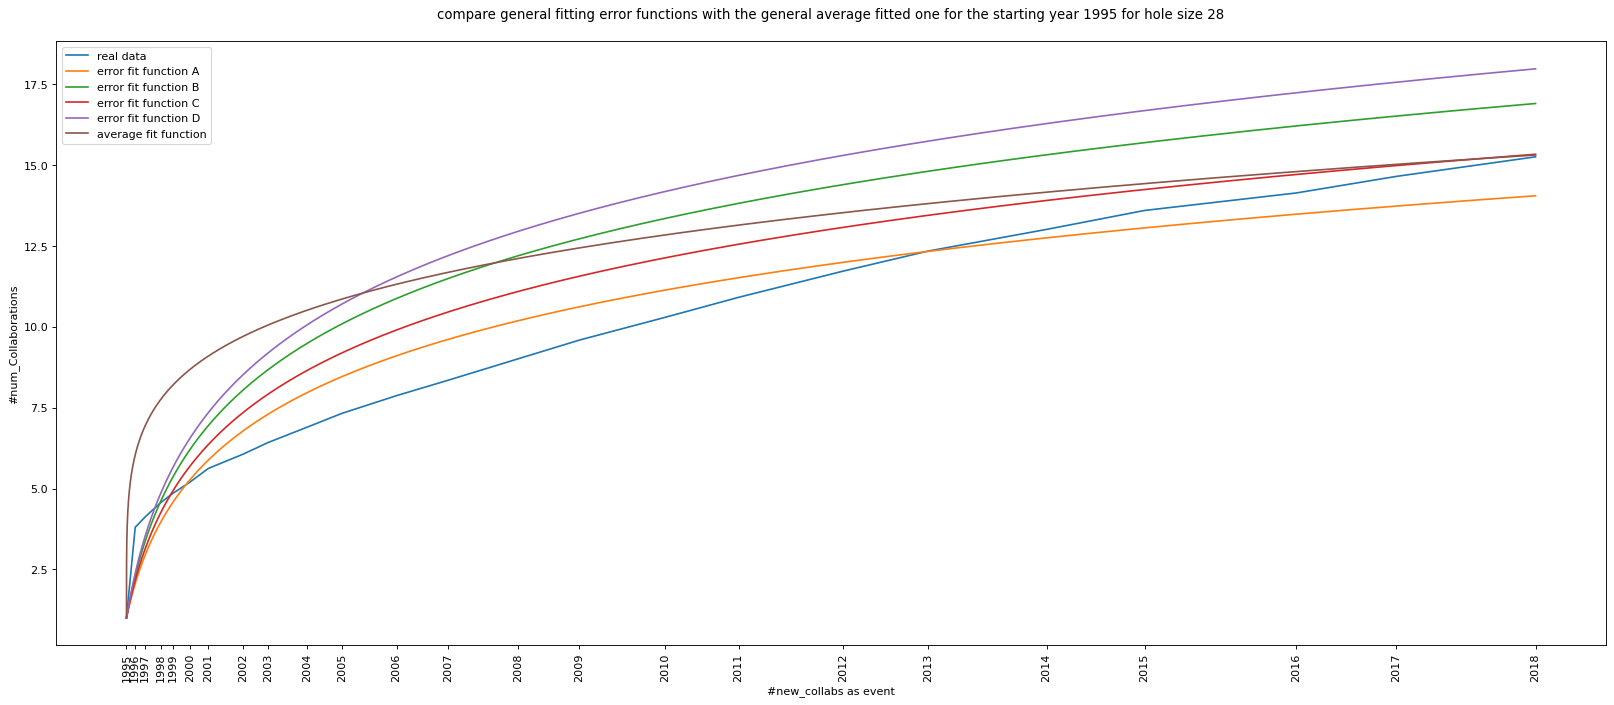

In [19]:
plot_all("1995")

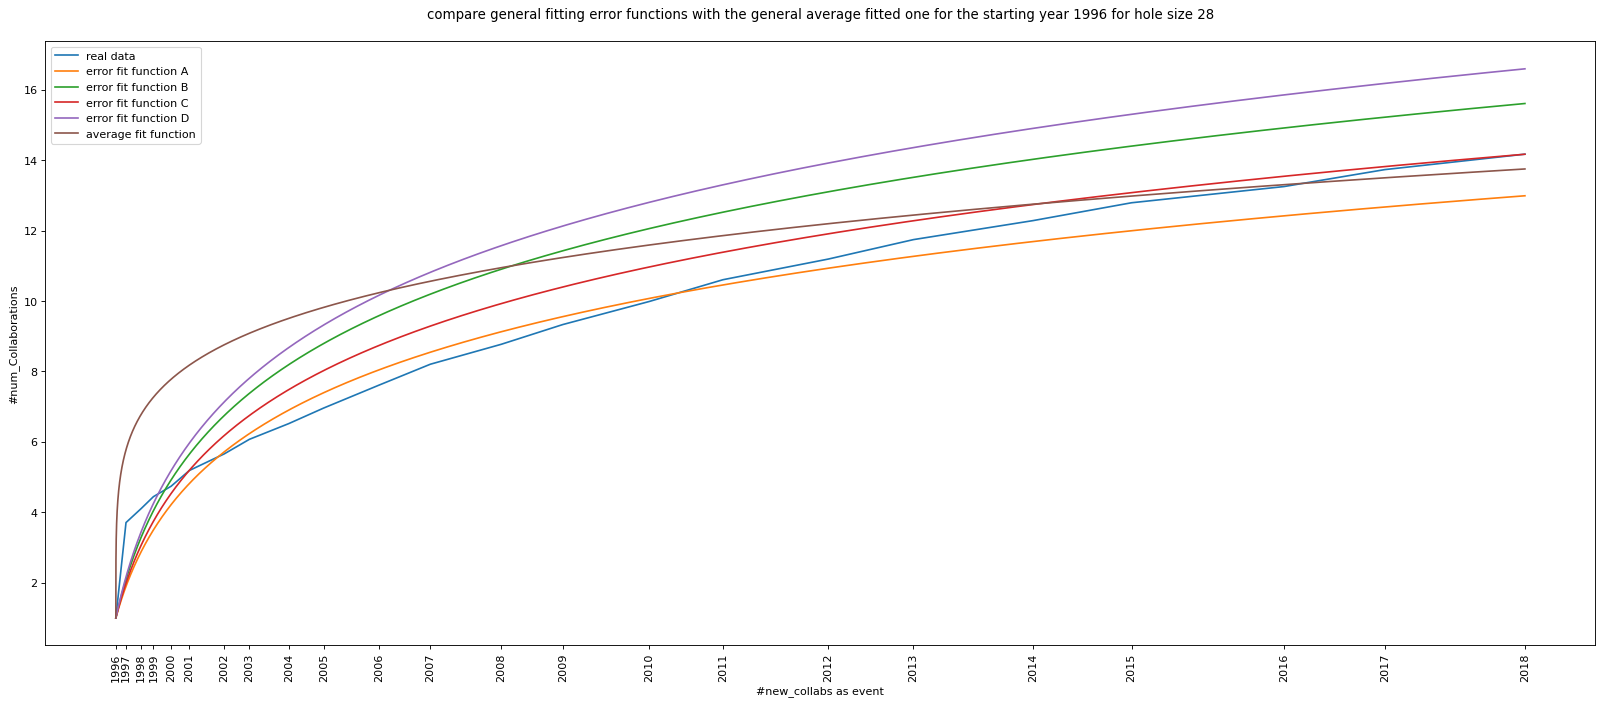

In [9]:
plot_all("1996")

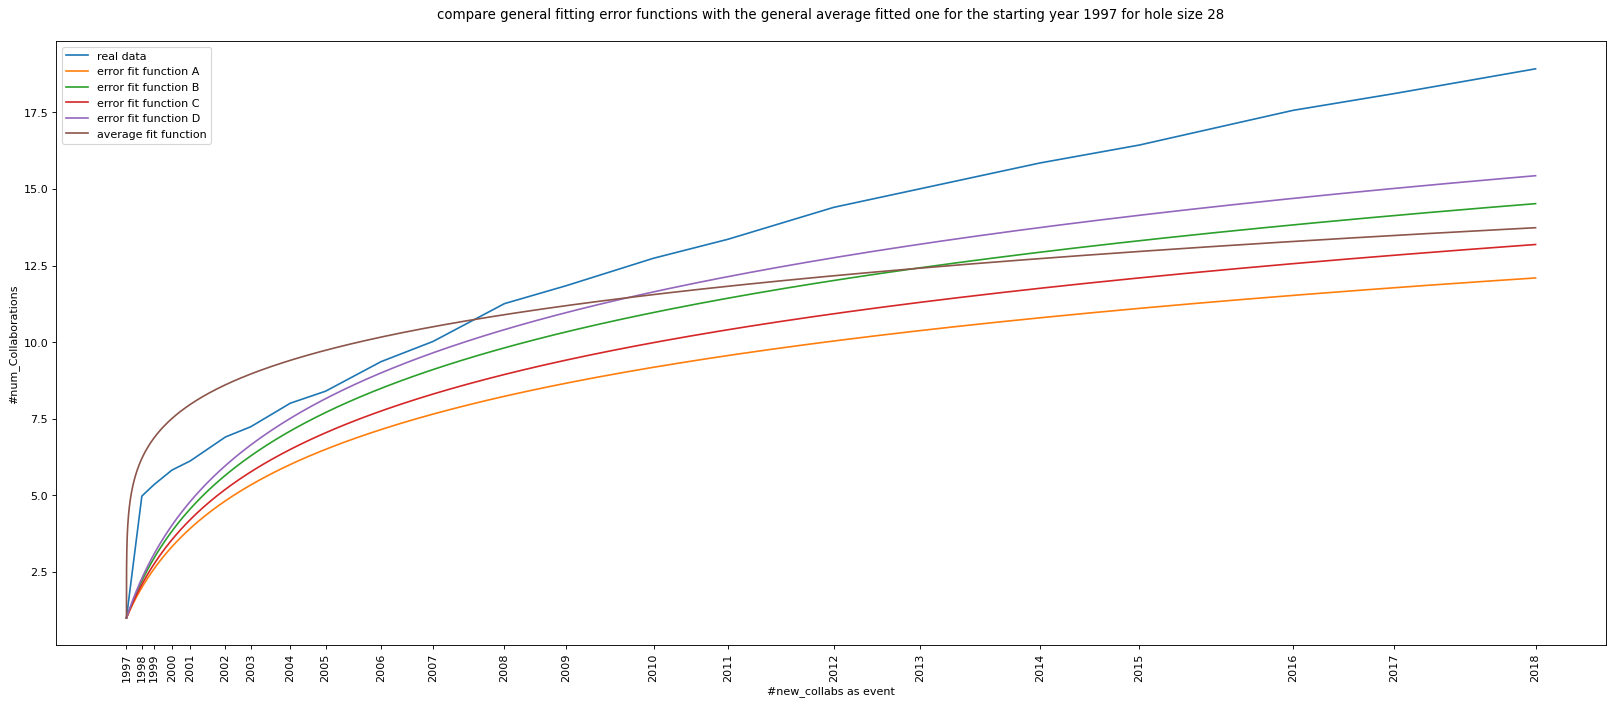

In [10]:
plot_all("1997")

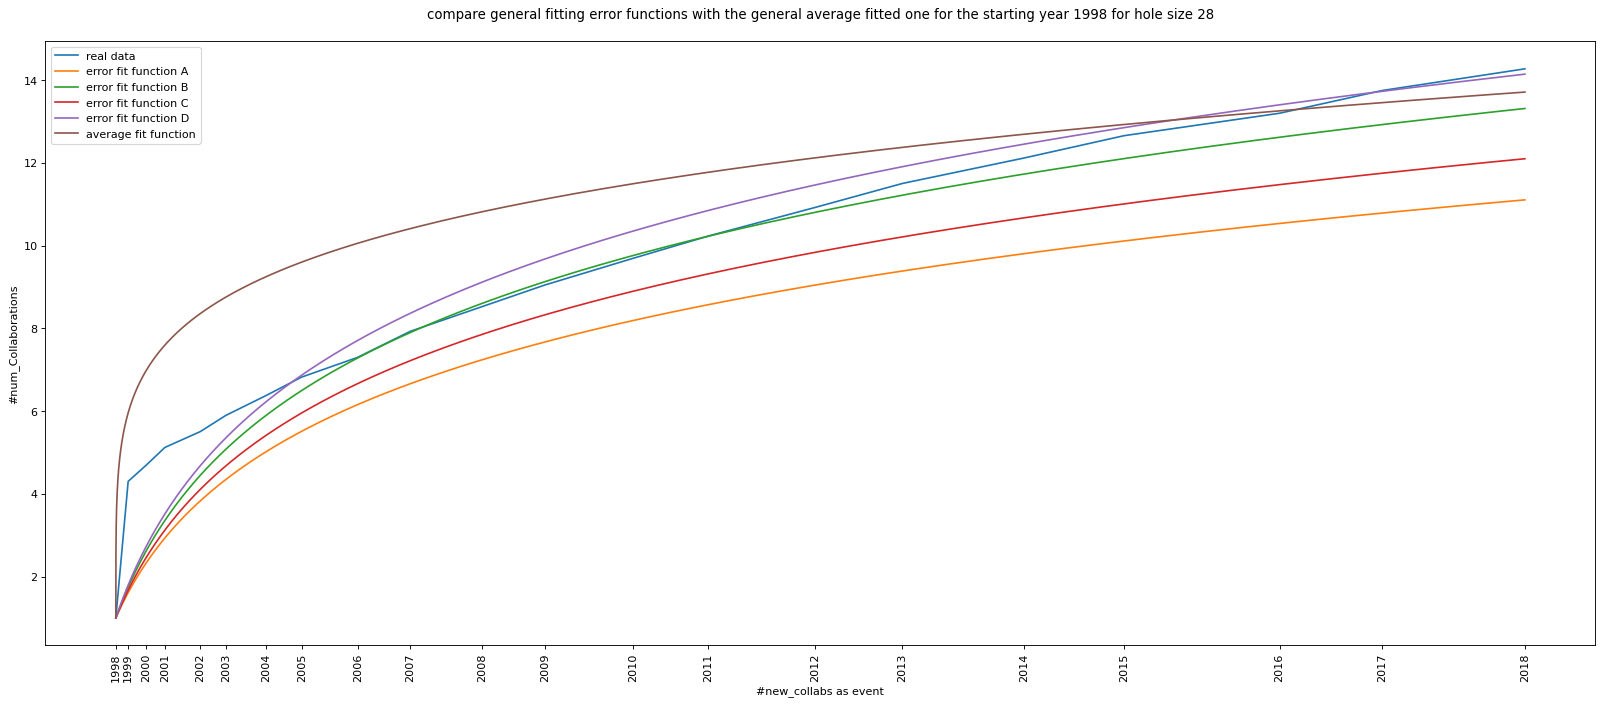

In [11]:
plot_all("1998")

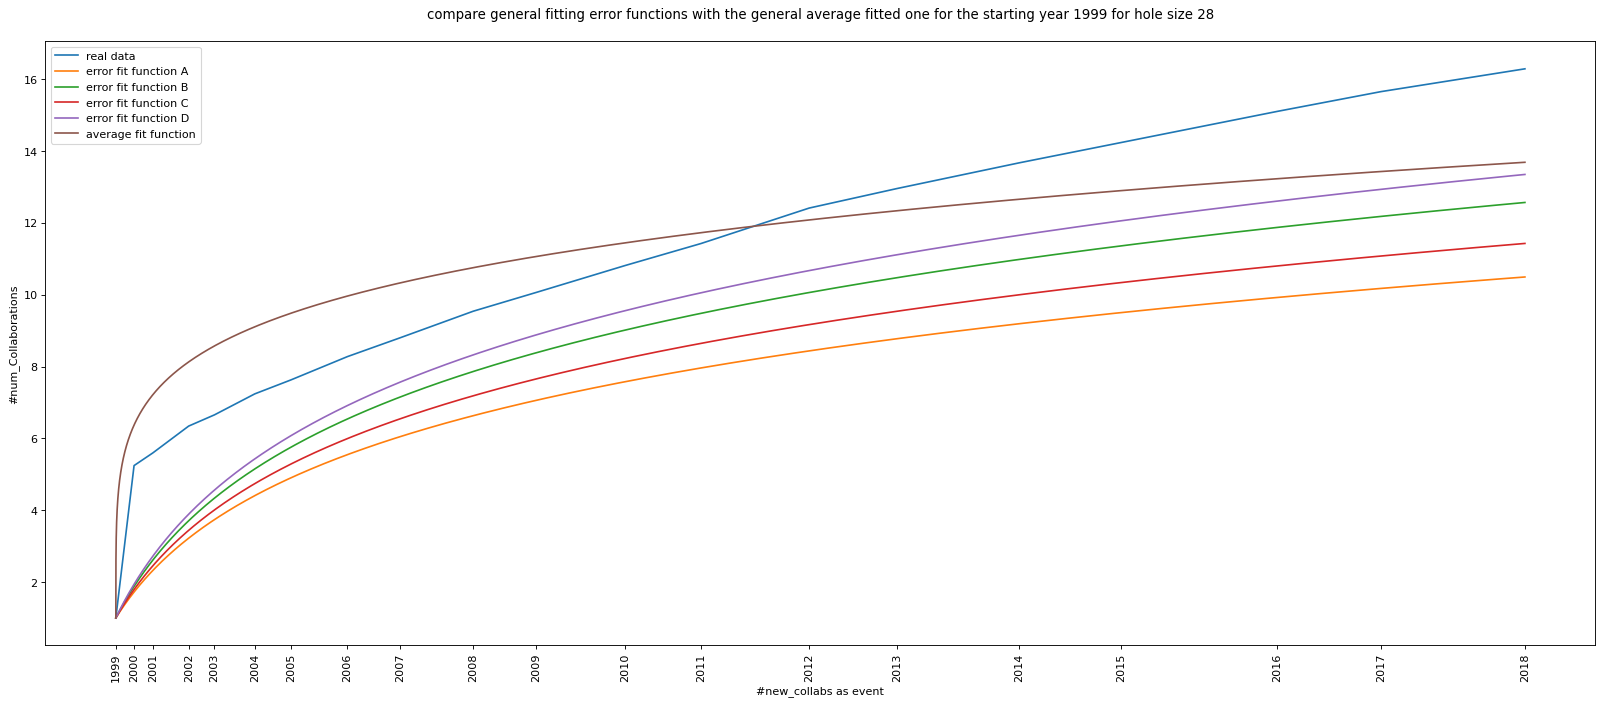

In [12]:
plot_all("1999")

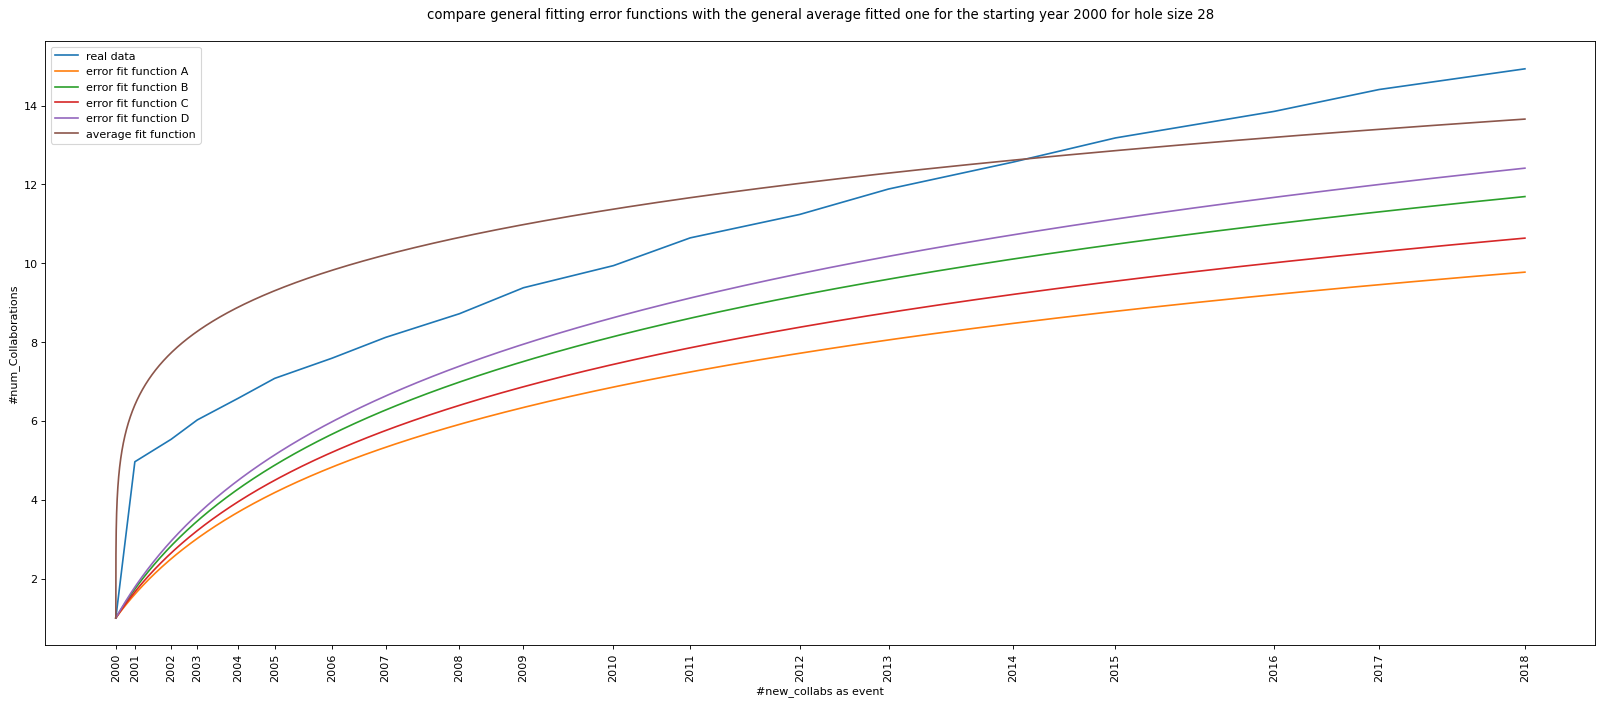

In [13]:
plot_all("2000")

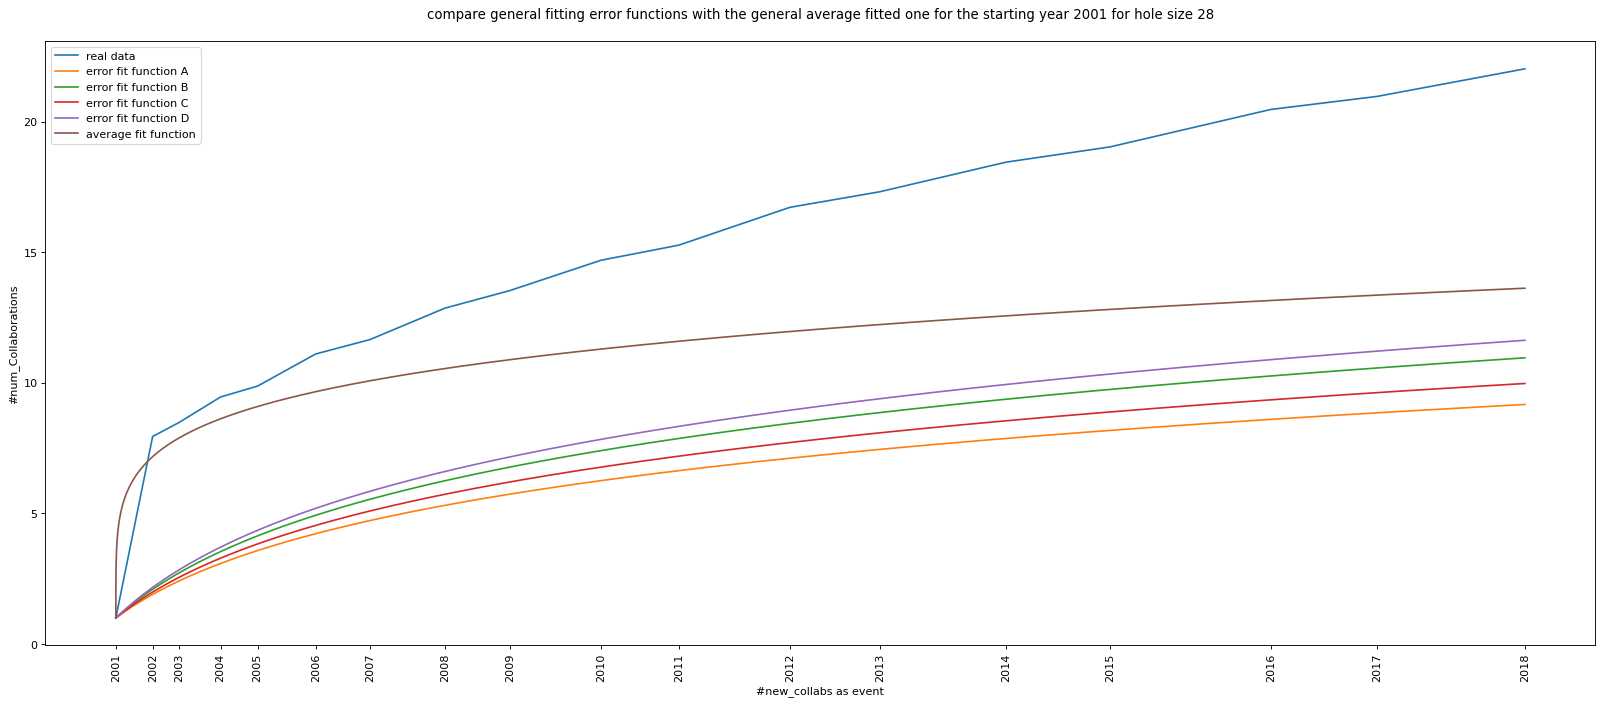

In [14]:
plot_all("2001")

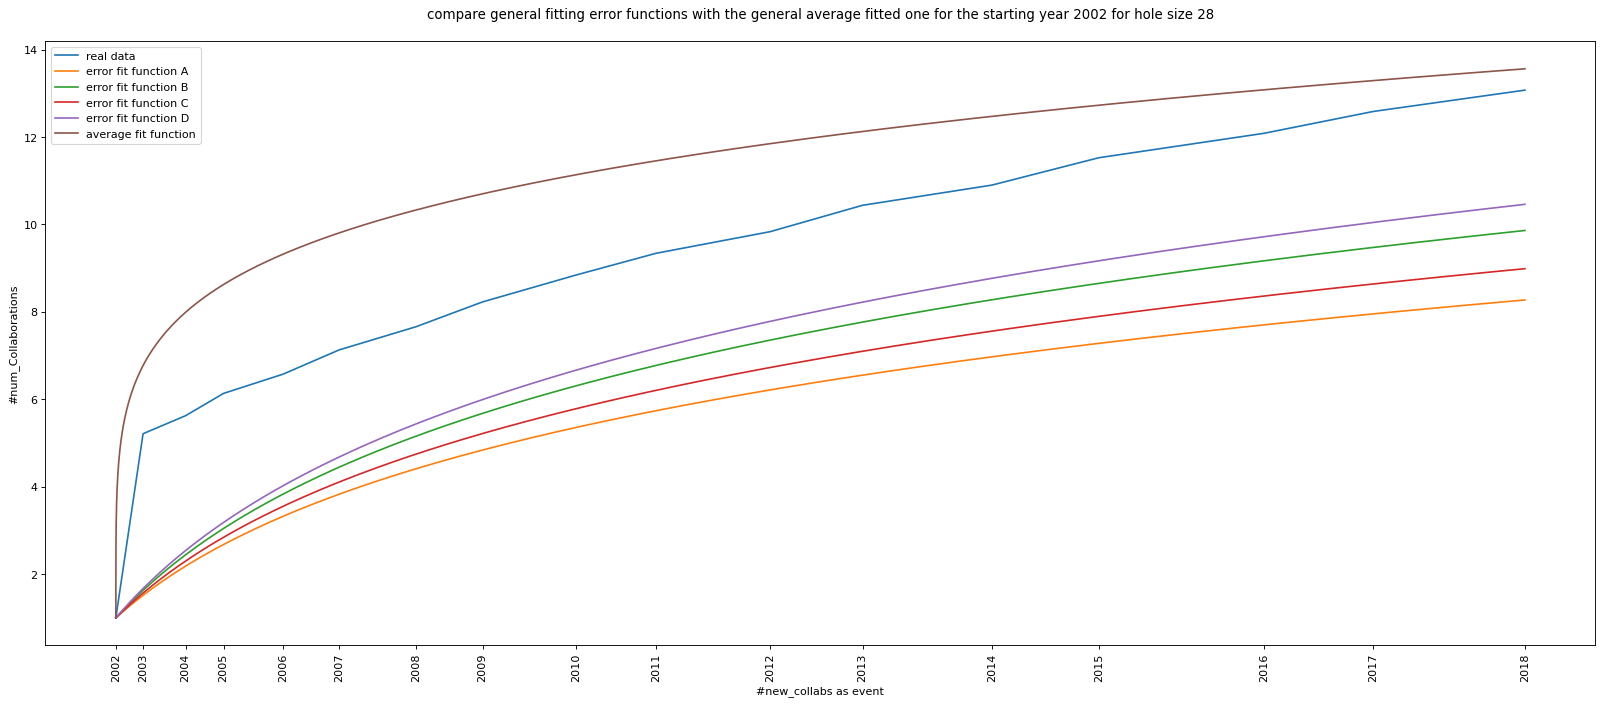

In [15]:
plot_all("2002")

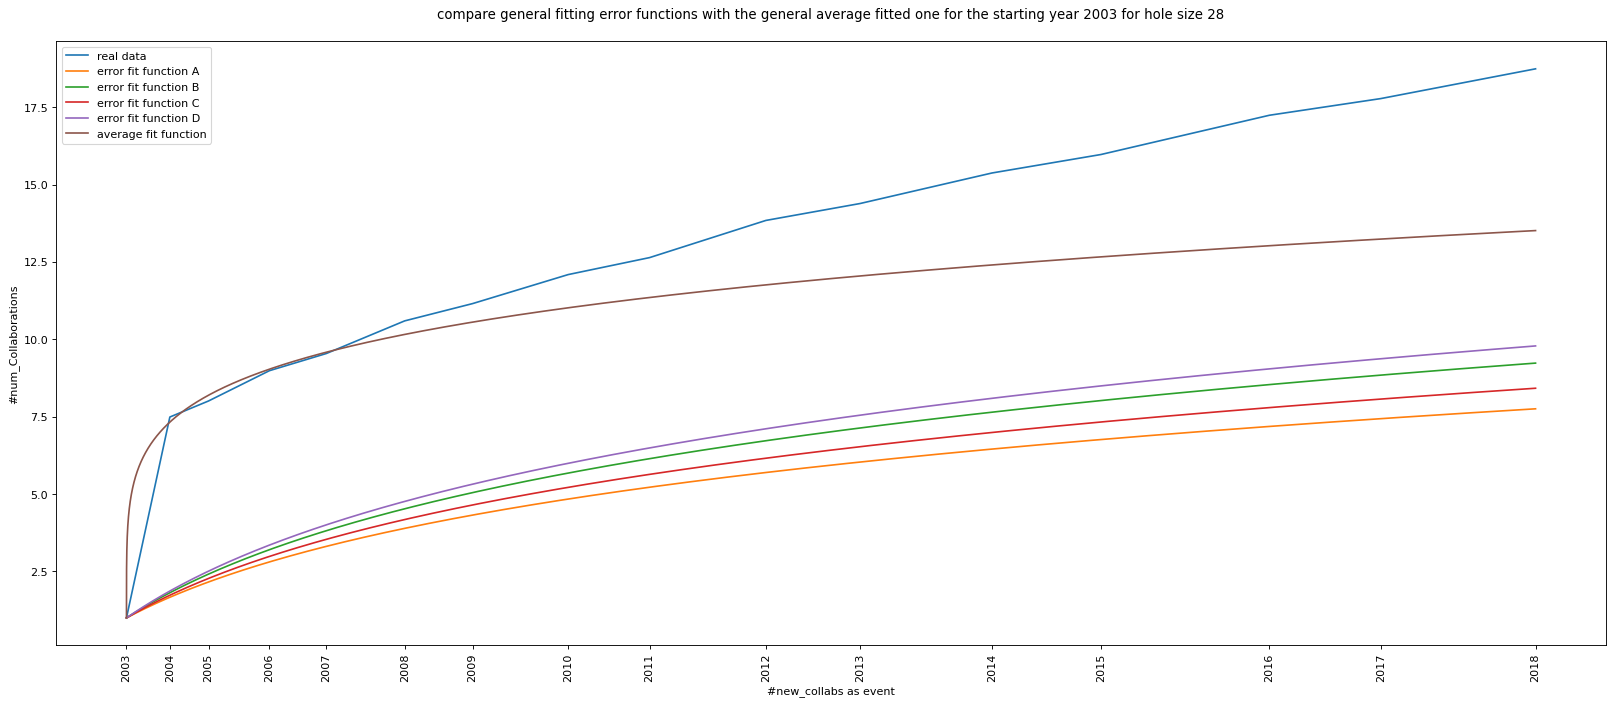

In [16]:
plot_all("2003")

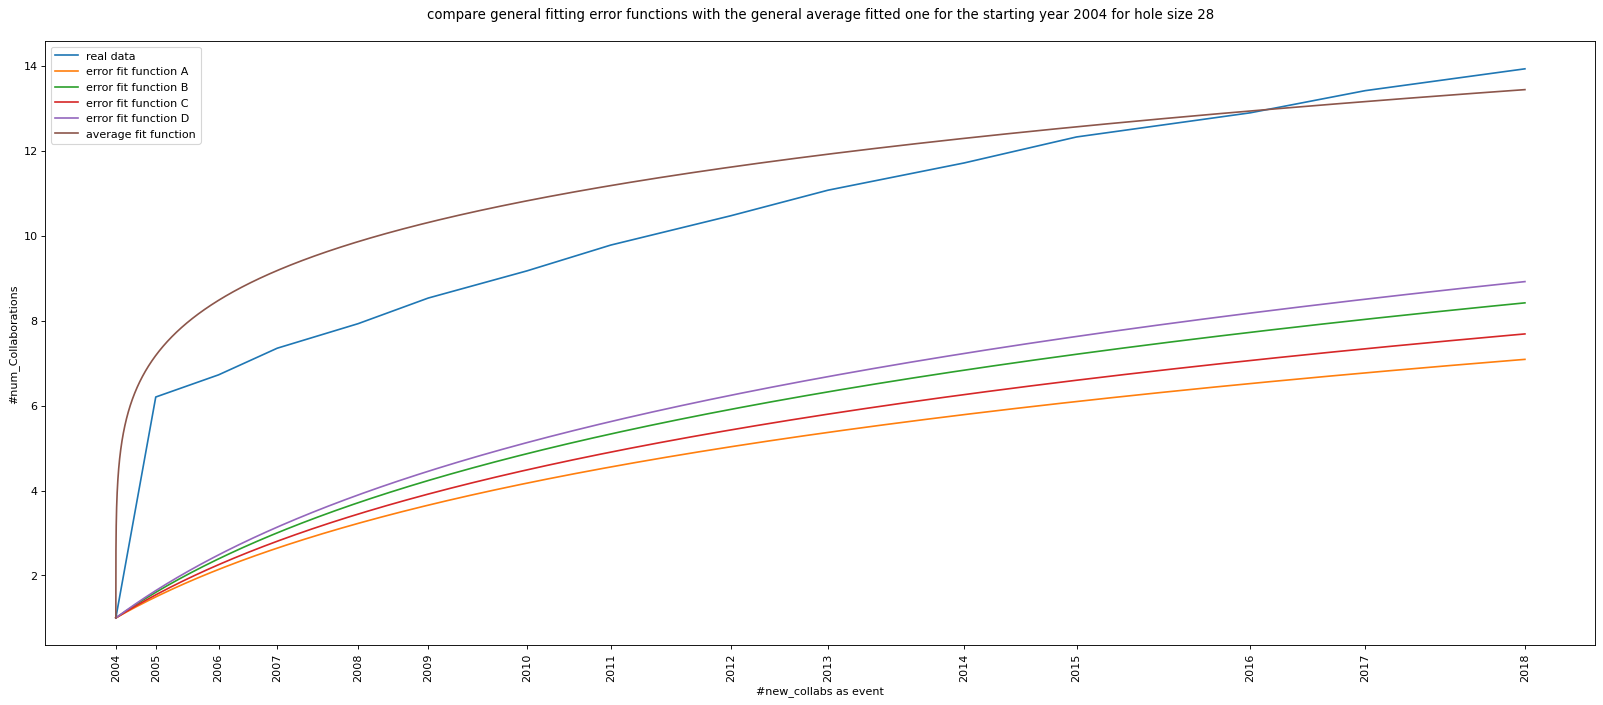

In [17]:
plot_all("2004")

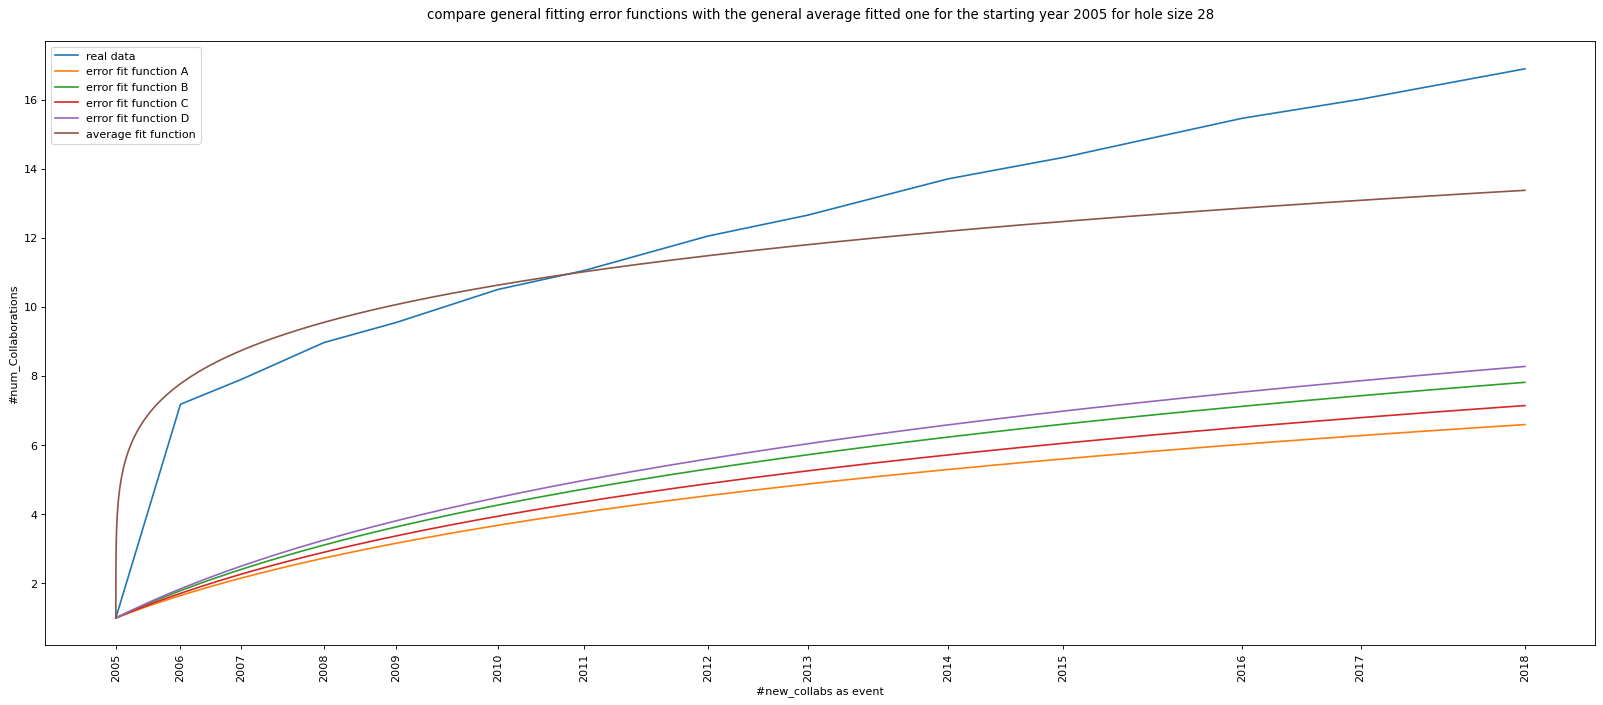

In [18]:
plot_all("2005")

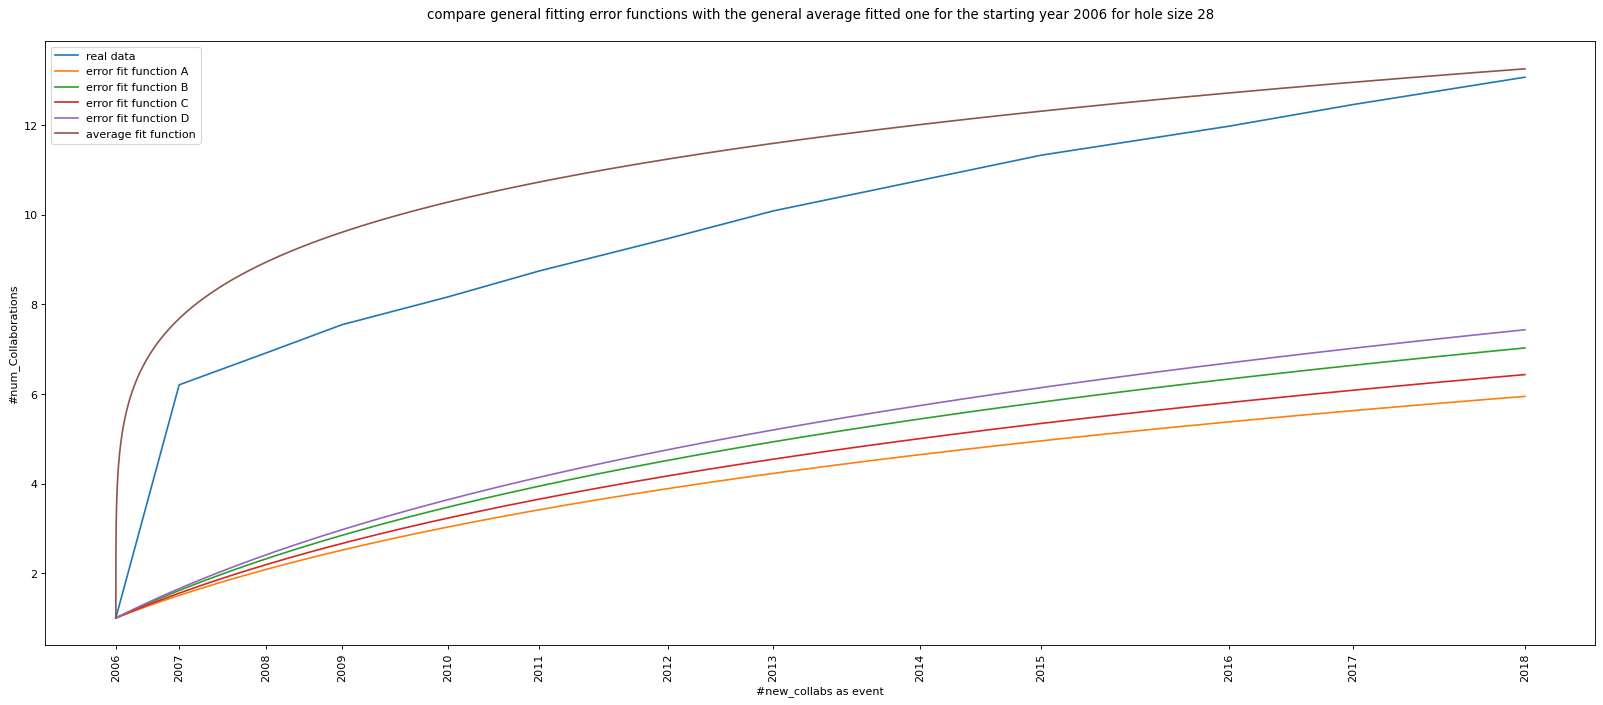

In [19]:
plot_all("2006")

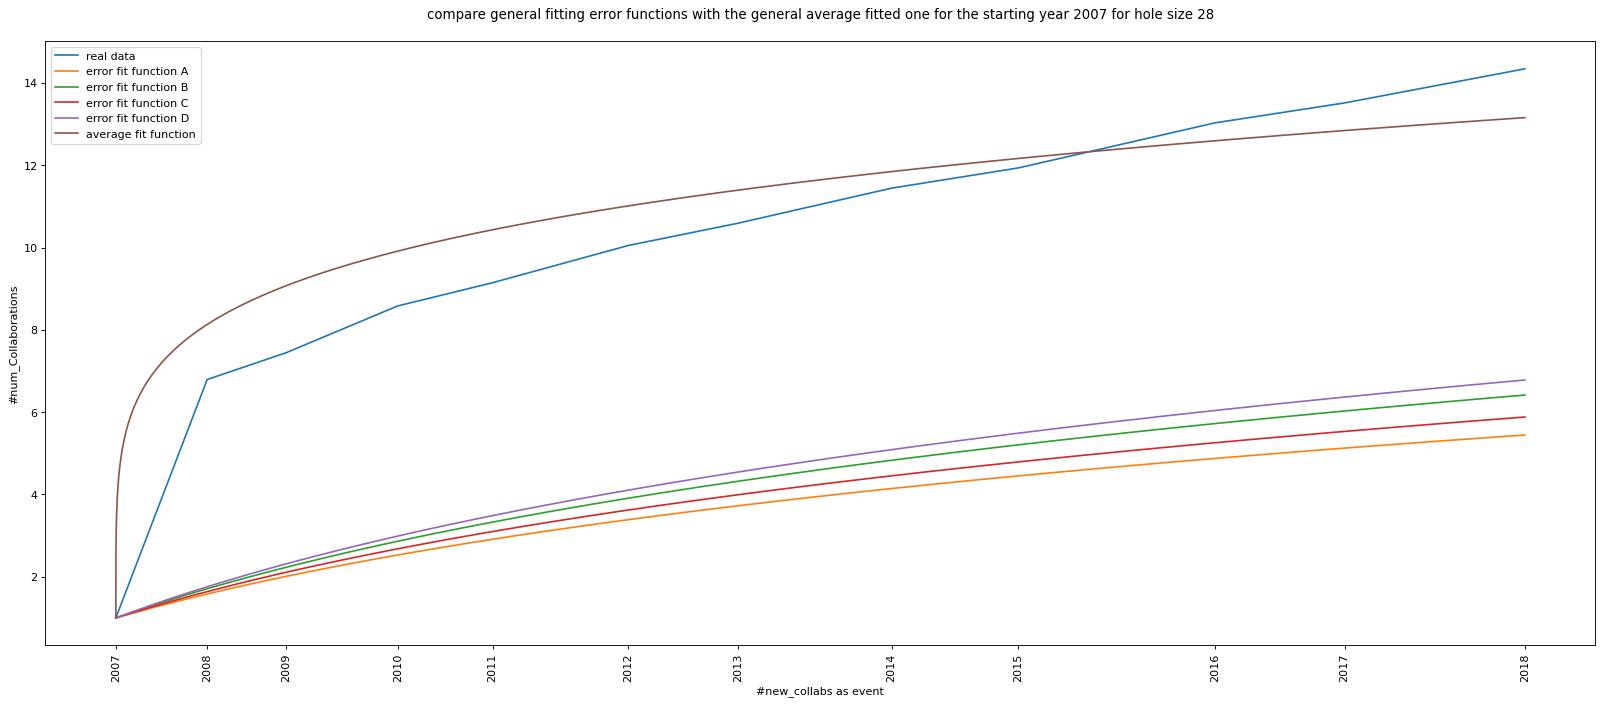

In [20]:
plot_all("2007")

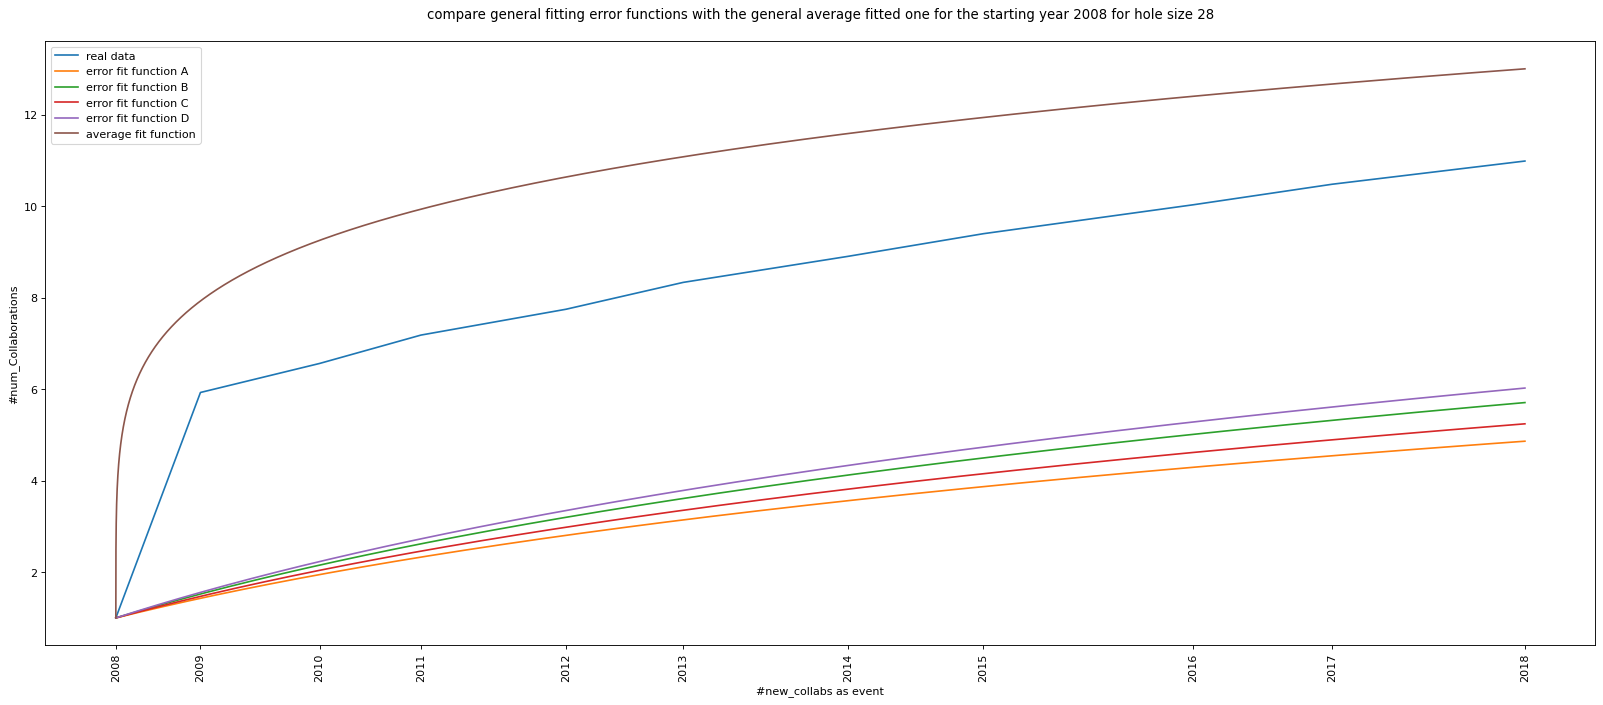

In [21]:
plot_all("2008")

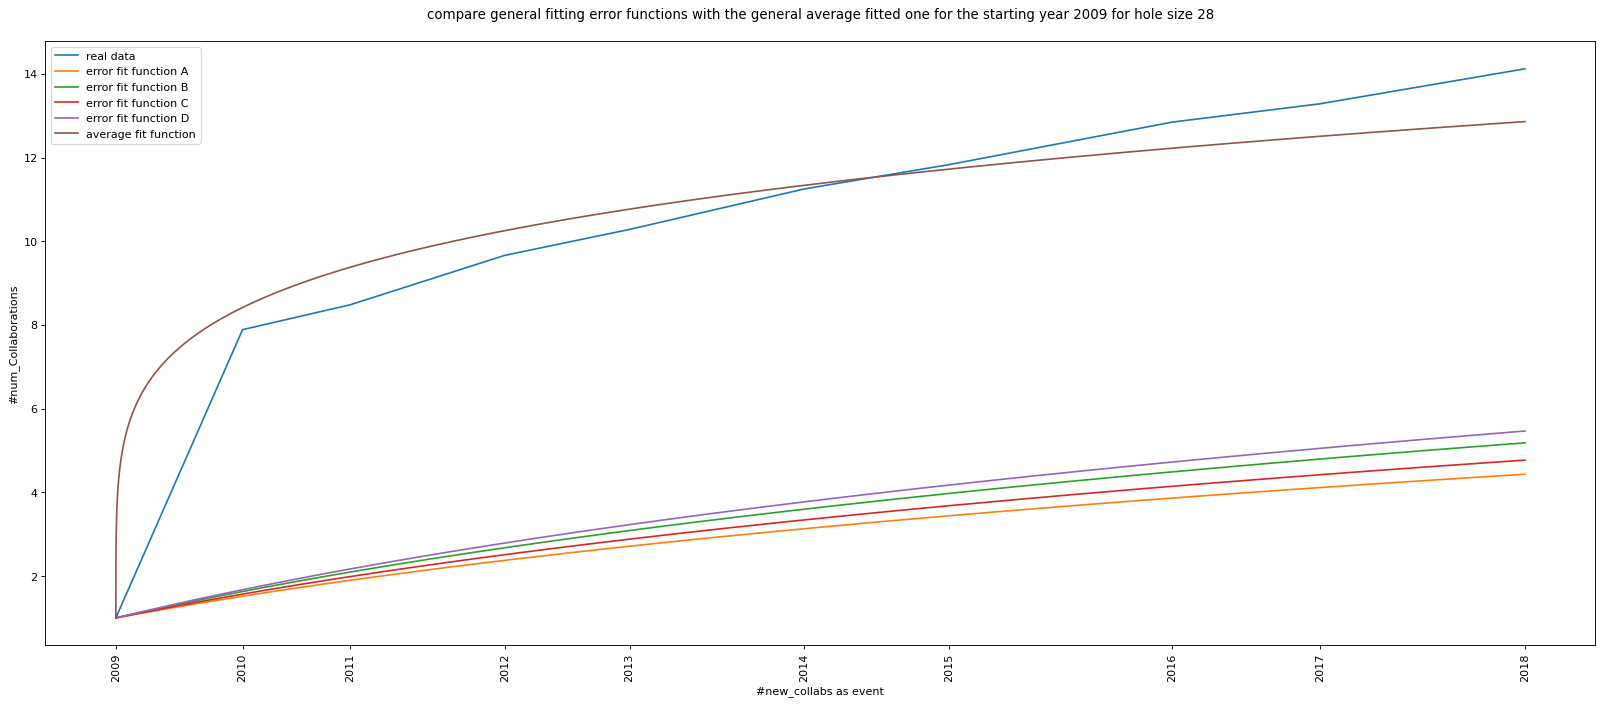

In [22]:
plot_all("2009")

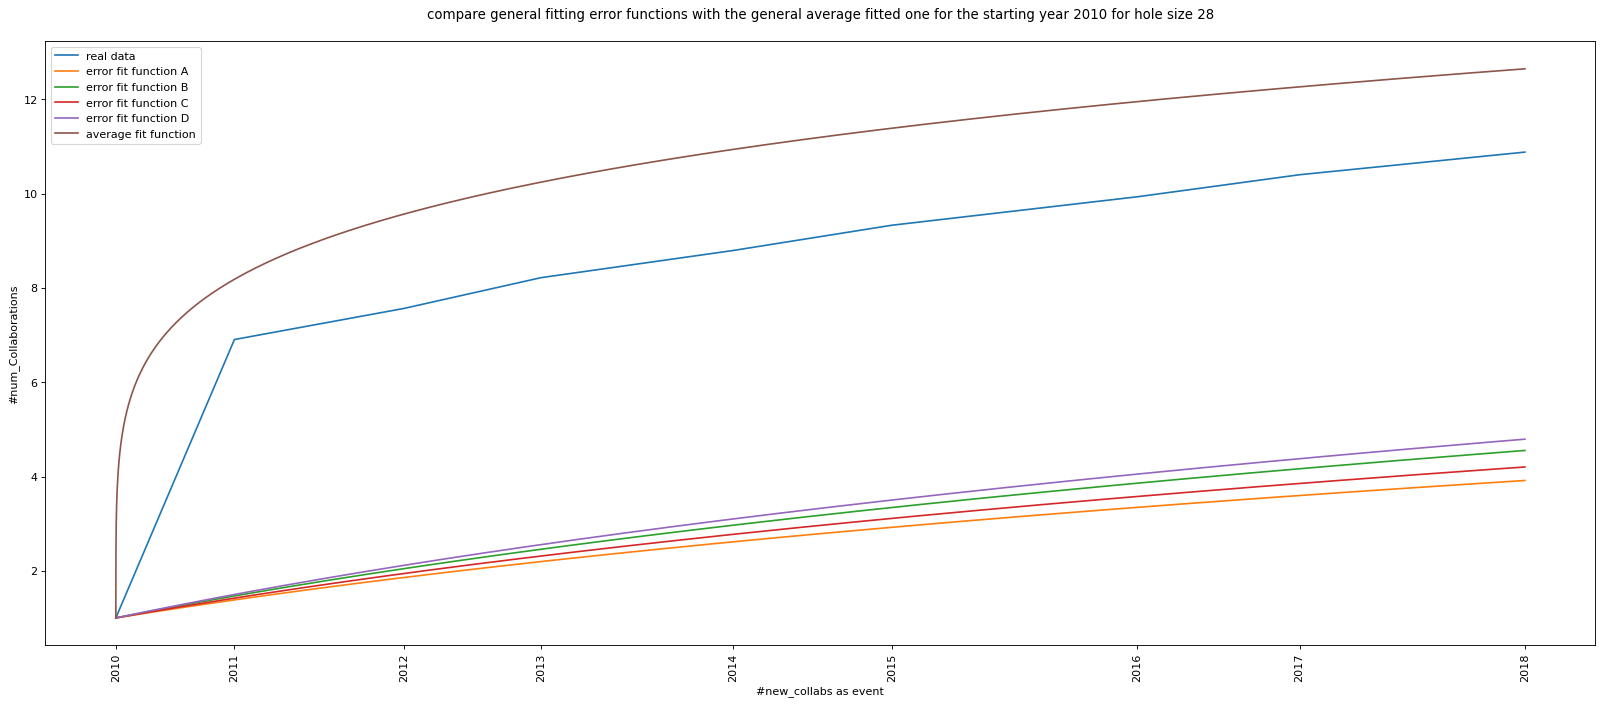

In [23]:
plot_all("2010")

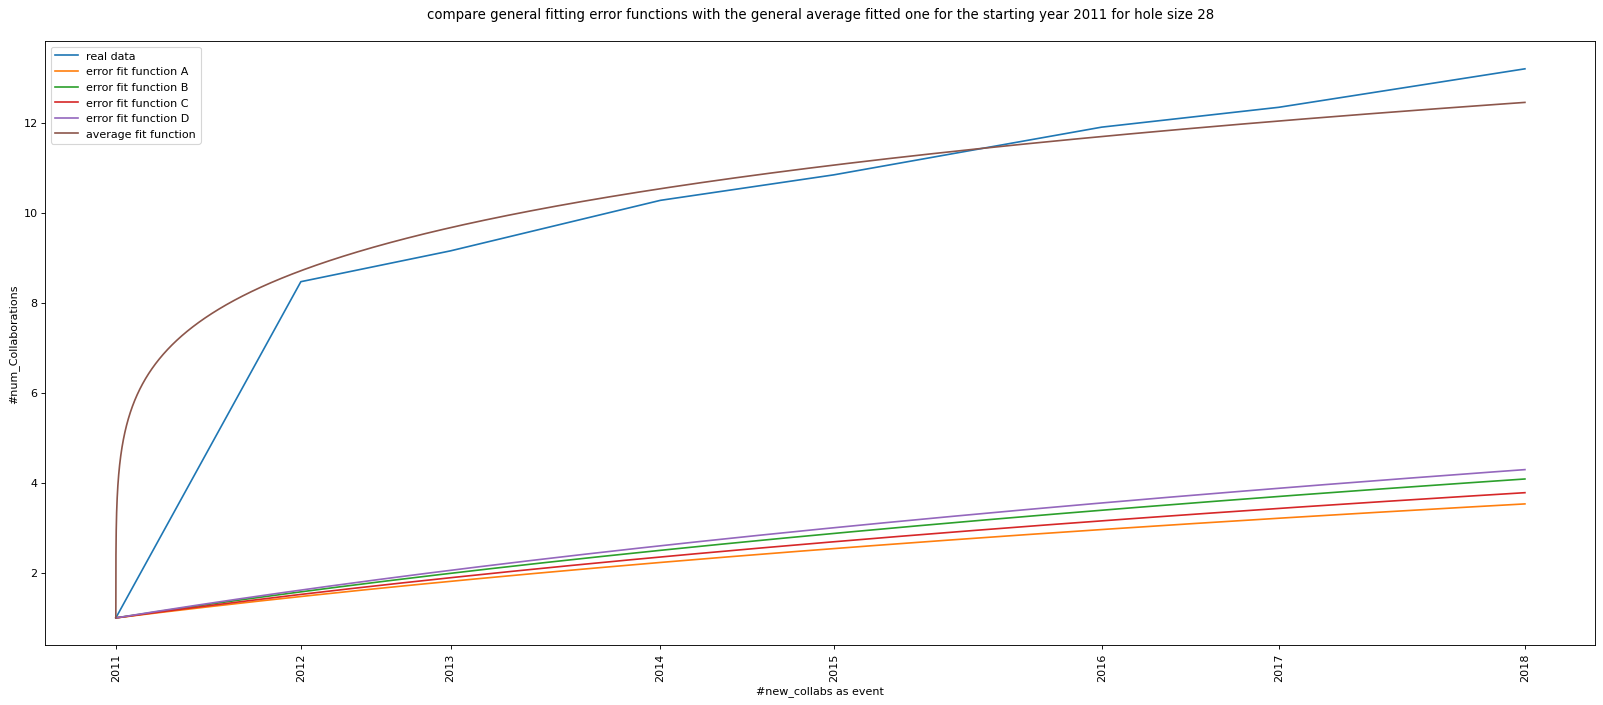

In [24]:
plot_all("2011")

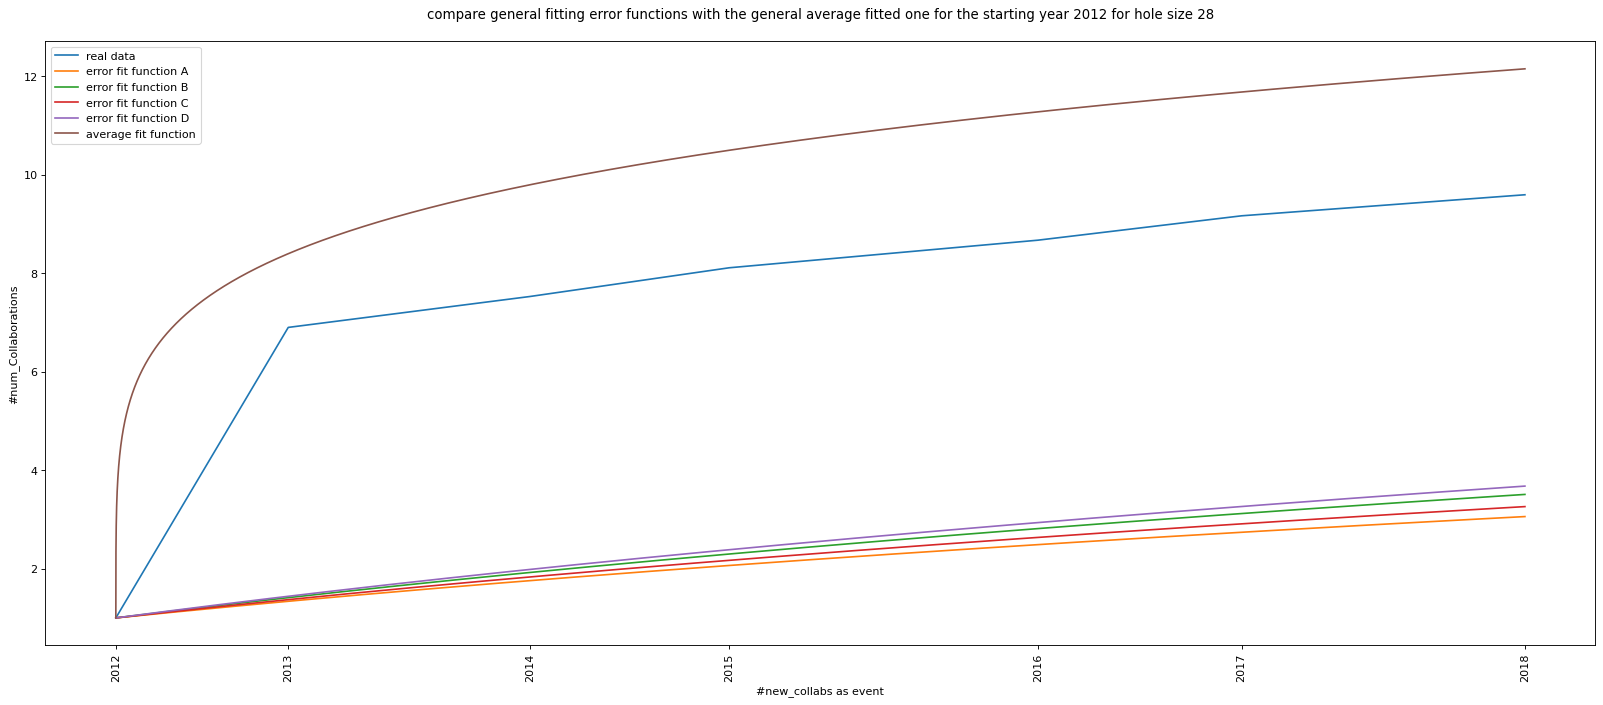

In [25]:
plot_all("2012")

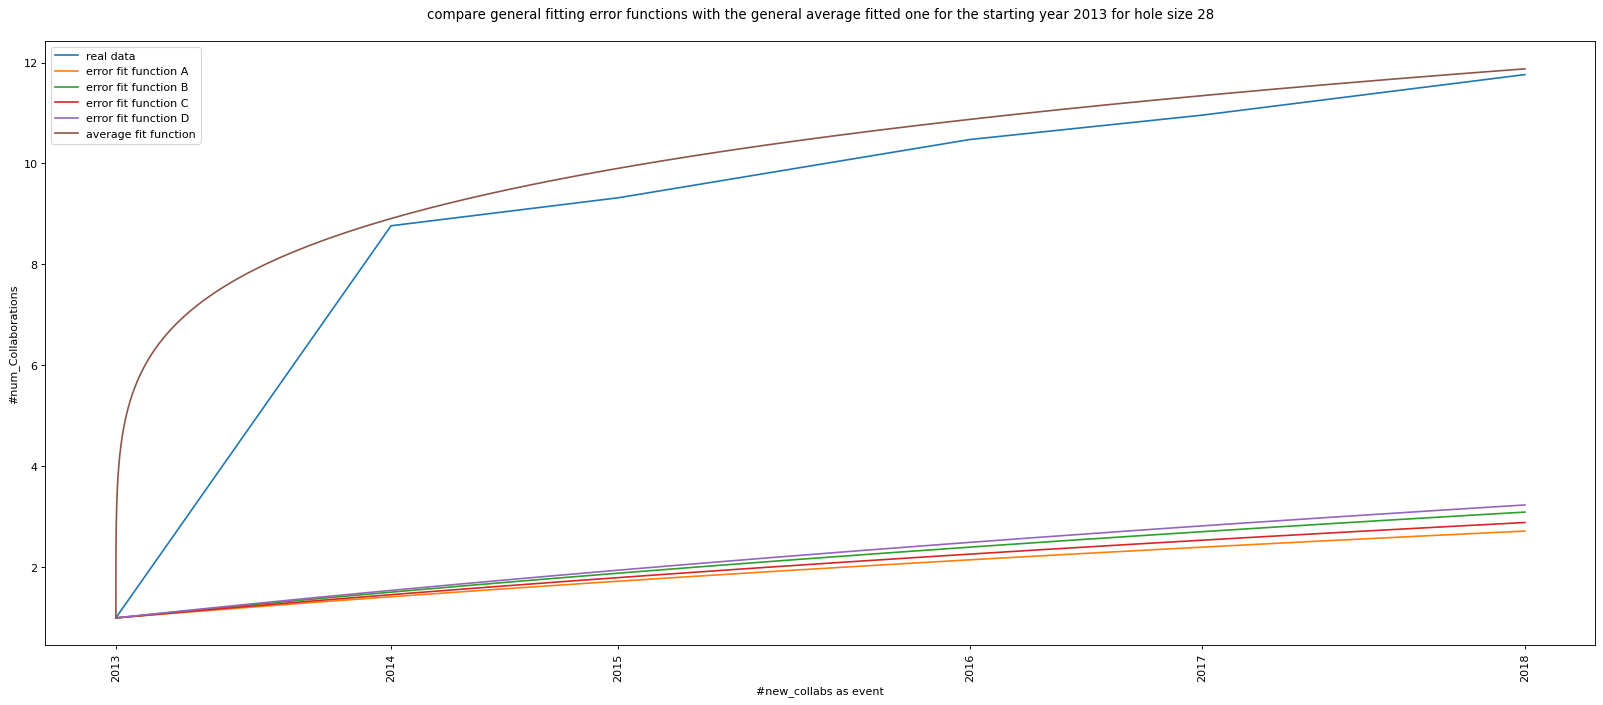

In [26]:
plot_all("2013")

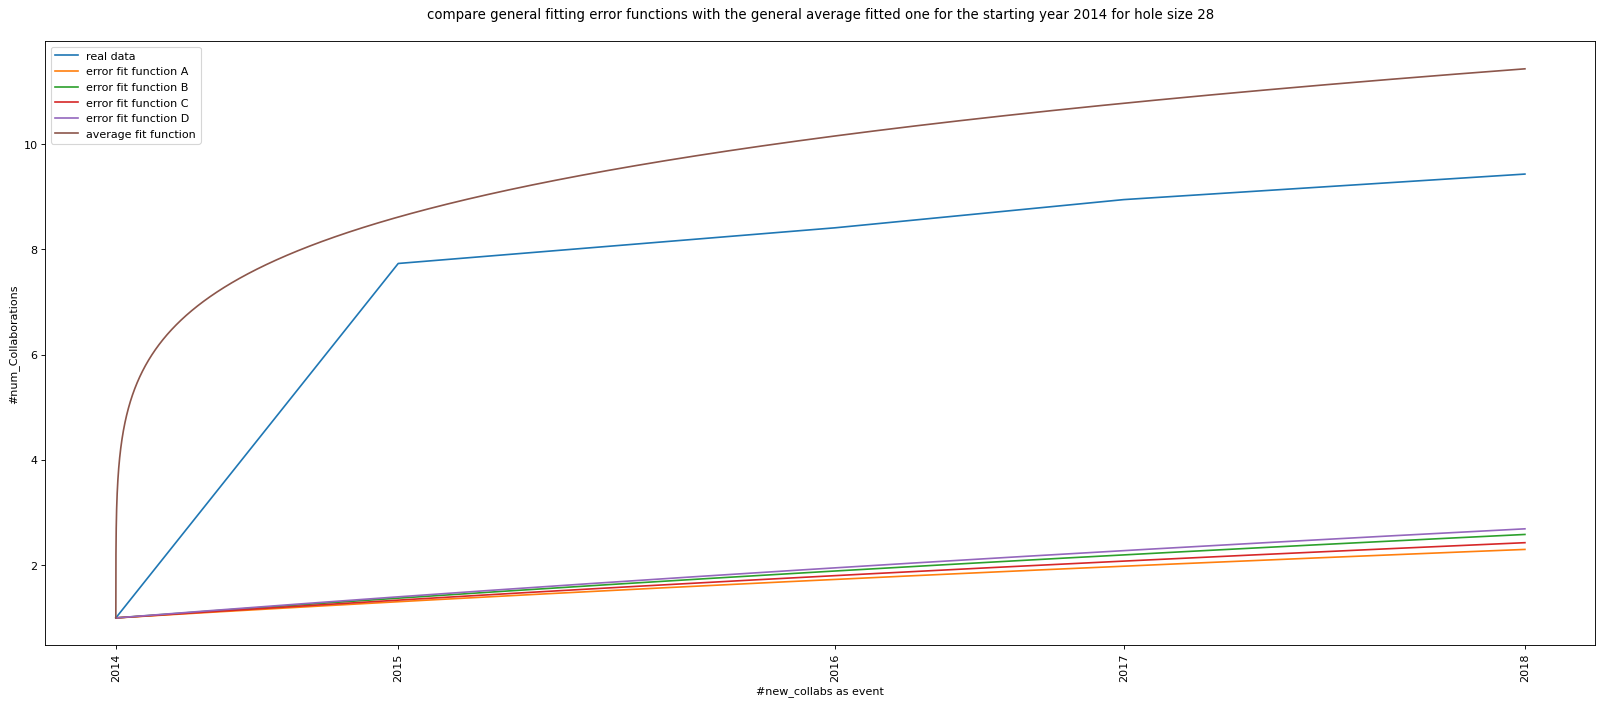

In [8]:
plot_all("2014")

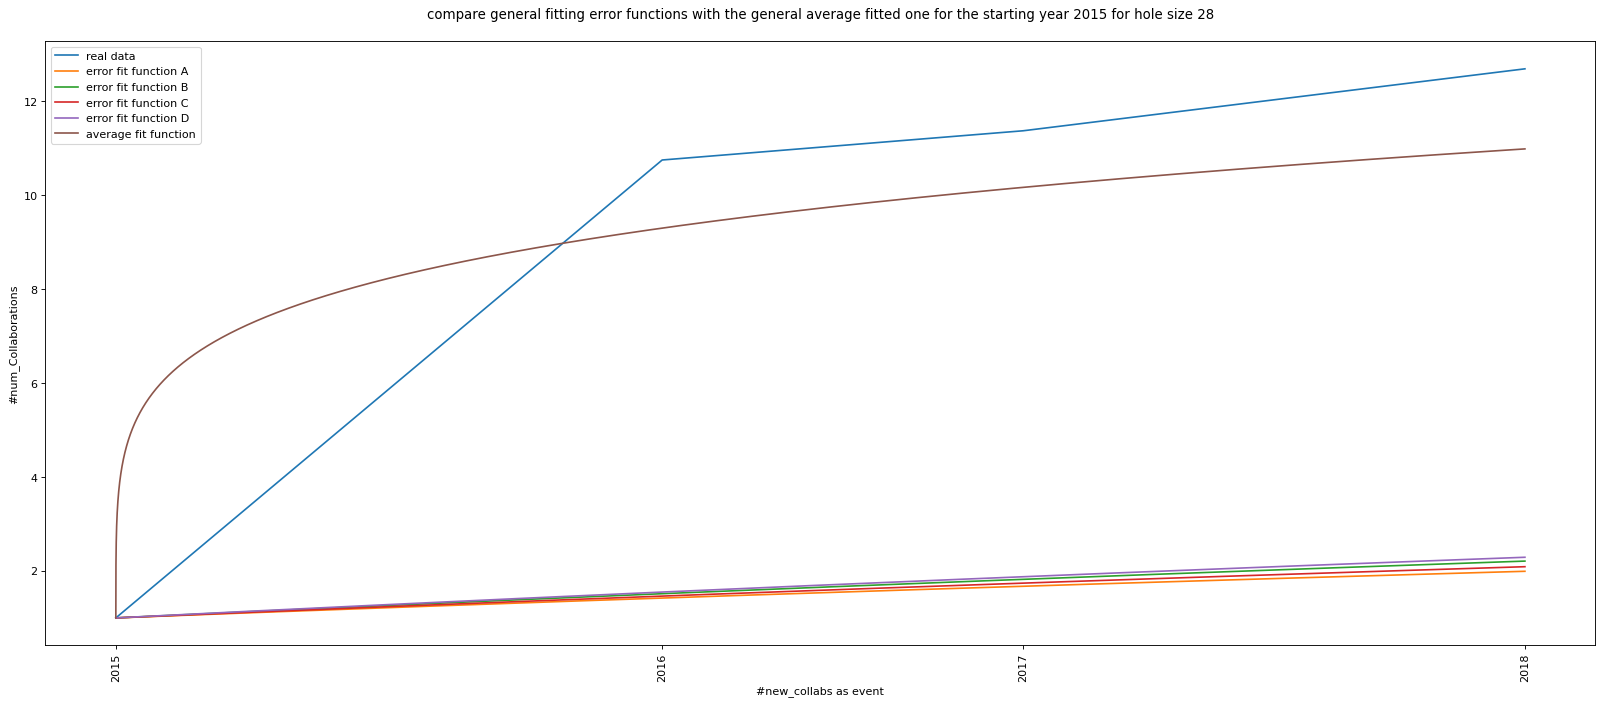

In [9]:
plot_all("2015")